In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
from sklearn.model_selection import KFold
# from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import xgboost as xgb
from collections import Counter
from sklearn.metrics import confusion_matrix
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm

**Reference**
https://blog.csdn.net/zwqjoy/article/details/109311133

# load data

In [120]:
def load_data():
    df_train = pd.read_csv(f'./data/training.csv',index_col='id')
    df_test = pd.read_csv(f'./data/test.csv',index_col='id')

    return df_train, df_test

In [121]:
df_train, df_test = load_data()

In [122]:
df_train

,event,var1,var2,var3,var4,var5,var6,var7,var8,split
id,,,,,,,,,,
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev
3,1,1.0,2.096510e+07,NaN,NaN,NaN,NaN,NaN,62.750000,dev
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev
...,...,...,...,...,...,...,...,...,...,...
238831,1,1.0,6.523118e+04,NaN,NaN,NaN,NaN,NaN,58.916667,dev
238832,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev
238833,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev


In [123]:
df_test

,event,var1,var2,var3,var4,var5,var6,var7,var8,split
id,,,,,,,,,,
0,1,1.0,9.248254e+07,0.908051,13.0,0.133592,0.027241,NaN,73.041667,test
1,1,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,test
2,1,1.0,6.718715e+06,7.035461,13.0,41.878073,-7.422937,NaN,76.250000,test
3,1,1.0,3.576348e+06,0.483255,13.0,60.801780,NaN,NaN,80.083333,test
4,1,1.0,8.443072e+06,NaN,NaN,0.525225,NaN,NaN,87.625000,test
...,...,...,...,...,...,...,...,...,...,...
59704,1,1.0,1.060430e+06,NaN,NaN,NaN,NaN,NaN,NaN,test
59705,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
59706,1,1.0,1.593264e+07,NaN,NaN,NaN,NaN,NaN,NaN,test


In [124]:
df_test[df_test['event']==0].shape

(1493, 10)

In [125]:
df_test[df_test['event']==1].shape

(58216, 10)

# EDA

## Feature and label distribution

In [66]:
df_train.describe()

,event,var1,var2,var3,var4,var5,var6,var7,var8
count,238836.000000,133036.000000,1.170360e+05,46637.000000,78187.000000,8287.000000,5939.000000,27542.000000,101147.000000
mean,0.974744,1.873951,5.989773e+06,16.772031,11.586977,289.199746,28.430493,20.646794,58.497153
std,0.156901,3.750522,3.444271e+07,125.433035,3.459597,5099.352261,2133.407579,6.460506,11.731754
min,0.000000,1.000000,0.000000e+00,0.000000,1.000000,0.000000,-3127.163978,2.000000,24.416667
25%,1.000000,1.000000,1.102558e+05,0.397341,13.000000,2.341317,0.012441,22.000000,49.833333
50%,1.000000,1.000000,8.042291e+05,1.509004,13.000000,8.105200,0.296218,24.000000,58.666667
75%,1.000000,1.000000,3.247496e+06,6.628049,13.000000,45.835062,1.378717,24.000000,66.666667
max,1.000000,121.000000,2.817428e+09,10175.481564,13.000000,334283.557143,164300.400000,24.000000,118.666667


In [67]:
df_test.describe()

,event,var1,var2,var3,var4,var5,var6,var7,var8
count,59709.000000,33419.000000,2.939900e+04,11531.000000,19358.000000,2105.000000,1522.000000,6823.000000,25251.000000
mean,0.974995,1.879949,6.126271e+06,16.838853,11.602955,301.994295,16.551022,20.713762,58.518438
std,0.156140,3.787302,3.219775e+07,117.764273,3.445142,3461.241920,506.565248,6.391736,11.788874
min,0.000000,1.000000,0.000000e+00,0.000000,1.000000,0.000000,-391.786290,2.000000,24.500000
25%,1.000000,1.000000,1.098130e+05,0.392199,13.000000,2.195123,0.001879,22.000000,49.916667
50%,1.000000,1.000000,8.263664e+05,1.470276,13.000000,7.976950,0.205745,24.000000,58.750000
75%,1.000000,1.000000,3.384614e+06,6.404448,13.000000,50.664706,1.211077,24.000000,66.666667
max,1.000000,111.000000,1.590072e+09,8615.982450,13.000000,116654.450000,19484.277852,24.000000,107.416667


### label distribution

In [68]:
def label_disb(df_train,df_test):
    """
    df: df_train & df_test
    """
    fig, ax = plt.subplots(1,2, figsize=(15,8))
    train_tmp = df_train['event'].value_counts().div(len(df_train)).mul(100)
    test_tmp = df_test['event'].value_counts().div(len(df_test)).mul(100)
    sns.barplot(x=train_tmp.index, y=train_tmp.values, ax=ax[0])
    sns.barplot(x=test_tmp.index, y=test_tmp.values, ax=ax[1])
    
#     ax = sns.barplot(x=tmp.index, y=tmp.values)
    ax[0].bar_label(ax[0].containers[0], fmt='%.f%%')
    ax[1].bar_label(ax[1].containers[0], fmt='%.f%%')
    ax[0].set_title(f"train Distribution of a target variable")
    ax[1].set_title(f"test Distribution of a target variable")
    ax[0].set_ylabel("Percentage [%]")
    plt.show()

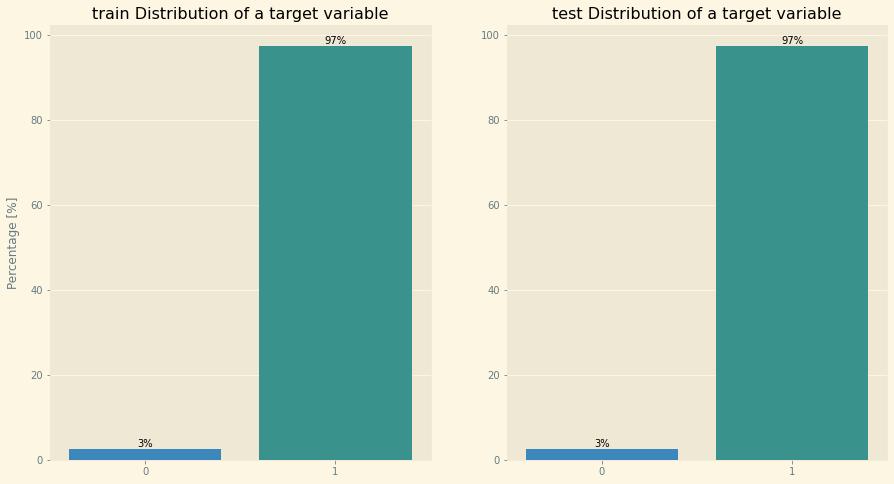

In [69]:
label_disb(df_train,df_test)

### feature distribution

In [70]:
def plot_disb(df_train,df_test):
    fig, ax = plt.subplots(nrows=8,ncols=2,figsize=(15,60))
    for i in range(1,9):
        col = df_train.columns[i]
        sns.kdeplot(df_train[col],ax=ax[i-1][0])
#         ax[i-1][0].hist(df_train[col])
        ax[i-1][0].set_title(f'{col} train distribution',fontsize=16)
        sns.kdeplot(df_test[col],ax=ax[i-1][1])
        ax[i-1][1].set_title(f'{col} test distribution',fontsize=16)
    plt.show()

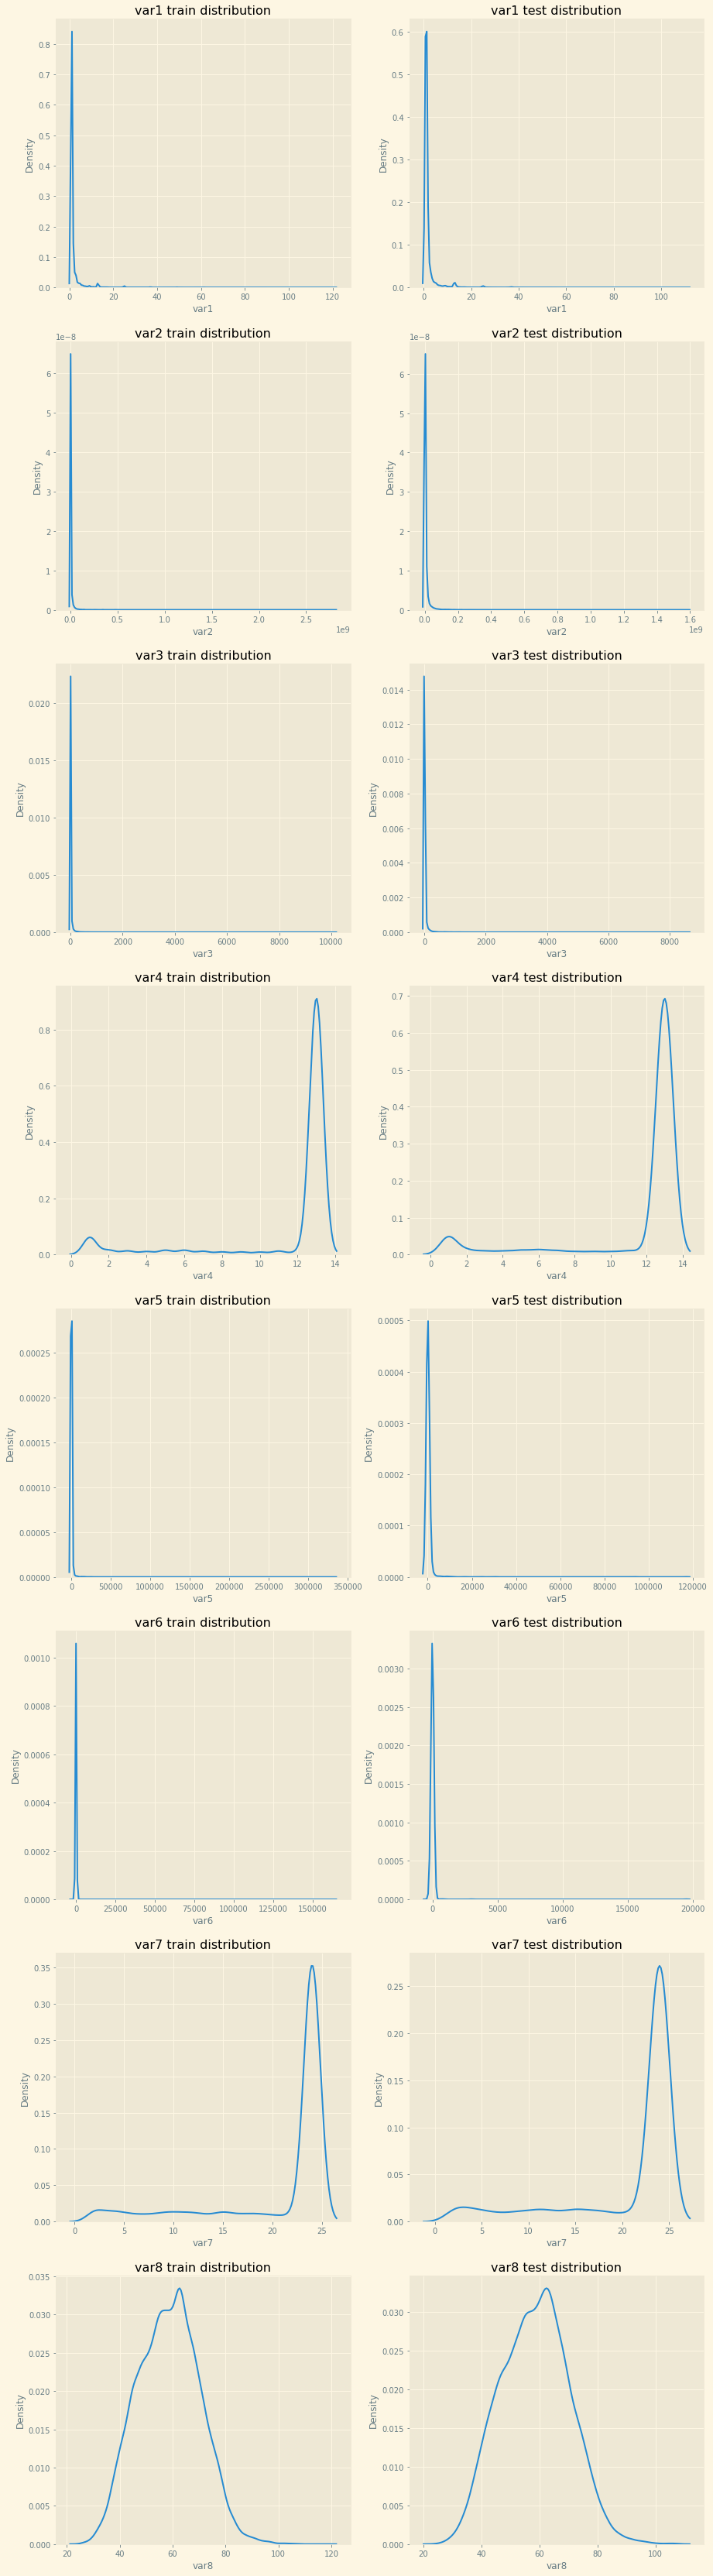

In [71]:
plot_disb(df_train,df_test)

We can see that the train data distribution is similar to the test data

## Missing Data

In [72]:
train_tmp = df_train.isna().sum().div(len(df_train)).mul(100).sort_values(ascending=False)
test_tmp = df_test.isna().sum().div(len(df_test)).mul(100).sort_values(ascending=False)

In [73]:
def Missing_count(train_tmp,test_tmp):
    plt.style.use('Solarize_Light2')
    fig, ax = plt.subplots(2,1, figsize=(15,12))
    sns.barplot(x=train_tmp.index, y=train_tmp.values, ax=ax[0])
    sns.barplot(x=test_tmp.index, y=test_tmp.values, ax=ax[1])
    ax[0].set_ylabel("Percentage [%]",fontsize=20), ax[1].set_ylabel("Percentage [%]",fontsize=20)
    ax[0].tick_params(axis='x',labelsize=20); ax[1].tick_params(axis='x',labelsize=20)
    ax[0].tick_params(axis='y',labelsize=20); ax[1].tick_params(axis='y',labelsize=20)
    plt.suptitle("Amount of missing data",fontsize=20)
    plt.tight_layout()
    plt.show()

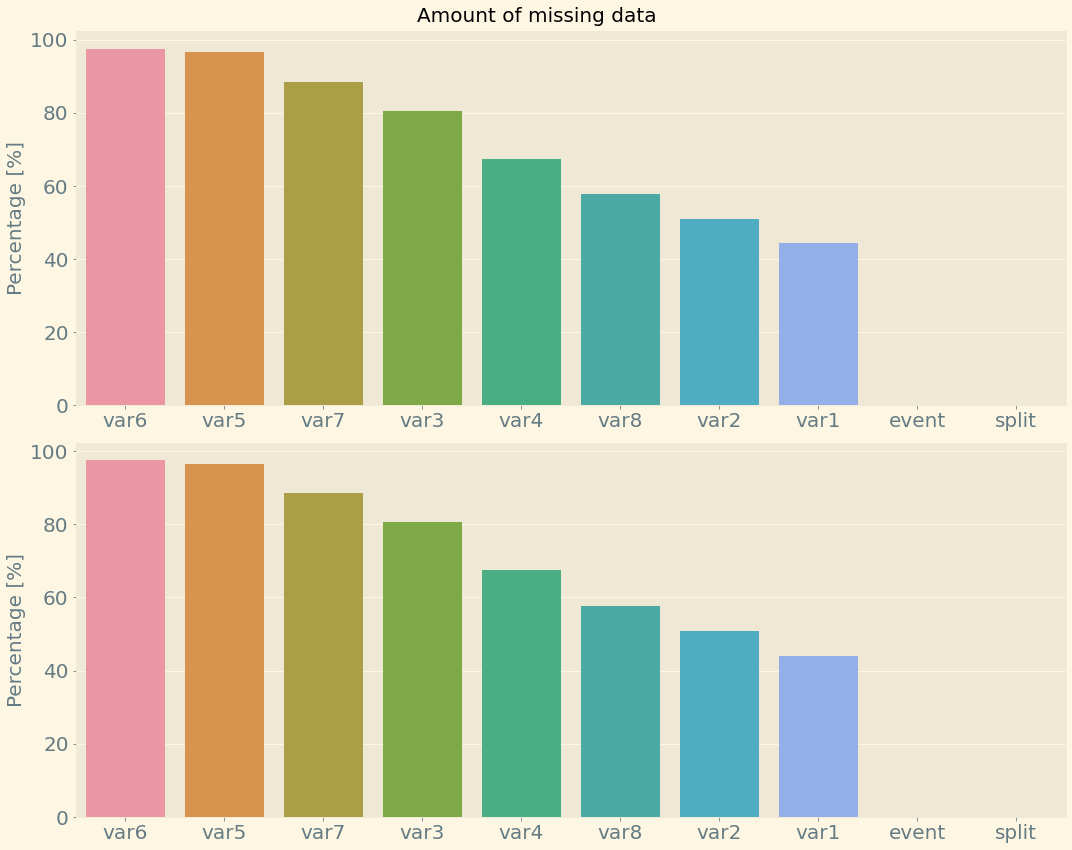

In [74]:
Missing_count(train_tmp,test_tmp)

## Correlation

In [75]:
features = [f'var{i}' for i in range(1,9)]

In [76]:
def plot_corr(df_train,df_test):
    train_corr = df_train.corr()
    test_corr = df_test.corr()
    mask_train=np.triu(np.ones_like(train_corr))
    mask_test=np.triu(np.ones_like(test_corr))

    fig, ax = plt.subplots(1,2, figsize=(16,7))
    sns.heatmap(train_corr, ax=ax[0], mask=mask_train ,vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
    sns.heatmap(test_corr, ax=ax[1], mask=mask_test,vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
    ax[0].set_title("Correlation of train features")
    ax[1].set_title("Correlation of test features")
    plt.show()

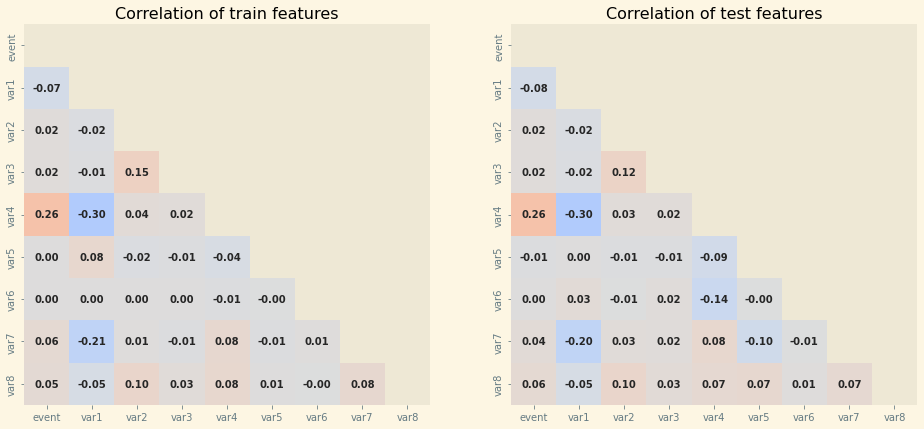

In [77]:
plot_corr(df_train,df_test)

# Model Training

We use xgboost and lightgbm which has several advantages
* It can deal with NANs
* No need standardization
* Deal with imbalanced sample

In [78]:
features =[ 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8']
label = 'event'
train_val_x, train_val_y = df_train[features].values, df_train[label].values
test_x, test_y = df_test[features].values, df_test[label].values

In [143]:
def plot_confusion_matrix(test_result):
    # 计算混淆矩阵
    cm = confusion_matrix(test_result['true'], test_result['pred'])

    # 可视化混淆矩阵
    fig = plt.figure(figsize=(8, 8))
    plt.matshow(cm, cmap=plt.cm.Reds, fignum=fig.number)
    plt.colorbar()
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Predicted Label')
    plt.xlabel('True Label')
    plt.show()

In [133]:
def test_xgb_model(model_list):
    xgb_test_result = pd.DataFrame(columns=[['pred','true']])
    xgb_test_result['true'] = test_y
    res = []
    for model in model_list:
        d_test = xgb.DMatrix(data=test_x,label=test_y)
        res.append(model.predict(d_test))

    pred_prob = np.mean(res,axis=0)
    xgb_test_result['prob'] = pred_prob
    xgb_test_result['pred'] = np.array([1 if x > 0.5 else 0 for x in pred_prob])
    
    amex_metric = amex_metric_mod(test_y,pred_prob)
    
    cm = confusion_matrix(xgb_test_result['true'], xgb_test_result['pred'])
    
    print("XGBoost Accuracy: {:.4f}".format(accuracy_score(xgb_test_result['pred'], xgb_test_result['true'])))
    print("XGBoost Precision: {:.4f}".format(precision_score(xgb_test_result['pred'], xgb_test_result['true'])))
    print("XGBoost Recall: {:.4f}".format(recall_score(xgb_test_result['pred'], xgb_test_result['true'])))
    print("XGBoost F1 Score: {:.4f}".format(f1_score(xgb_test_result['pred'], xgb_test_result['true'])))
    print("XGBoost avg Precision: {:.4f}".format(average_precision_score(xgb_test_result['pred'], xgb_test_result['true'])))
    print("XGBoost AUC: {:.4f}".format(roc_auc_score(xgb_test_result['pred'], xgb_test_result['true'])))
    print("XGBoost Amex metric: {:.4f}".format(amex_metric))
    
    Neg_Recall_rate = cm[0,0]/(cm[0,0]+cm[0,1])
    Neg_Precision_rate = cm[0,0]/(cm[0,0]+cm[0,1])
    Neg_F1_score = Neg_Recall_rate * Neg_Precision_rate / (Neg_Recall_rate+Neg_Precision_rate)
    print(f'Recall rate for Negative sample:{round(Neg_Recall_rate,4)}')
    return xgb_test_result

We use xgboost and lightgbm which have several advantages

## Version1

Simply using Xgboost train model in 5-folds

### Training 5-folds

In [126]:
# XGBoost参数
params1 = {
#     'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.3,
    'max_depth': 6,
    'subsample': 0.8,
#     'verbose': 10,
    'random_state': 42,
#     'scale_pos_weight':3/97
}

In [127]:
def train_xgb_model1(params1):
    # 五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    acc_lgb, precision_lgb, recall_lgb, f1_lgb, ap_lgb, auc_lgb = [], [], [], [], [], []
    acc_xgb, precision_xgb, recall_xgb, f1_xgb, ap_xgb, auc_xgb = [], [], [], [], [], []
    lgbm_test_result = pd.DataFrame({'true':test_y})
    xgb_test_result = pd.DataFrame({'true':test_y})
    threshold = 0.5
    kf_iter = 0
    model_list = []
    for train_idx, valid_idx in kf.split(train_val_x):
        kf_iter += 1
        X_train, X_valid = train_val_x[train_idx], train_val_x[valid_idx]
        y_train, y_valid = train_val_y[train_idx], train_val_y[valid_idx]

        dtrain = xgb.DMatrix(data=X_train,label=y_train)
        dval = xgb.DMatrix(data=X_valid,label=y_valid)

        watch_list = [(dtrain, 'train'), (dval, 'valid')]

        xgb_model = xgb.train(params=params1, 
                              dtrain=dtrain, 
                              num_boost_round=100, 
                              early_stopping_rounds=20,
                              verbose_eval=20,
                              evals=watch_list
                             )
        
        model_list.append(xgb_model)

        prob_pred_xgb = xgb_model.predict(dval) # pred probability
        y_pred_xgb = np.array([1 if x > 0.5 else 0 for x in prob_pred_xgb]) # pred value 0,1

        acc_xgb.append(accuracy_score(y_valid, y_pred_xgb))
        precision_xgb.append(precision_score(y_valid, y_pred_xgb))
        recall_xgb.append(recall_score(y_valid, y_pred_xgb))
        f1_xgb.append(f1_score(y_valid, y_pred_xgb))
        ap_xgb.append(average_precision_score(y_valid, y_pred_xgb))
        auc_xgb.append(roc_auc_score(y_valid, y_pred_xgb))


    #     xgb_test_result[kf_iter] = xgb_model.predict(d_test)


    print("XGBoost Accuracy: {:.4f}".format(np.mean(acc_xgb)))
    print("XGBoost Precision: {:.4f}".format(np.mean(precision_xgb)))
    print("XGBoost Recall: {:.4f}".format(np.mean(recall_xgb)))
    print("XGBoost F1 Score: {:.4f}".format(np.mean(f1_xgb)))
    print("XGBoost Avg Precision: {:.4f}".format(np.mean(ap_xgb)))
    print("XGBoost AUC: {:.4f}".format(np.mean(auc_xgb)))
    return model_list

In [128]:
model_list1 = train_xgb_model1(params1)

[0]	train-auc:0.72087	valid-auc:0.70706
[20]	train-auc:0.76820	valid-auc:0.73626
[40]	train-auc:0.78069	valid-auc:0.73371
[46]	train-auc:0.78269	valid-auc:0.73270
[0]	train-auc:0.72019	valid-auc:0.70966
[20]	train-auc:0.76564	valid-auc:0.73954
[40]	train-auc:0.77884	valid-auc:0.74054
[52]	train-auc:0.78667	valid-auc:0.73781
[0]	train-auc:0.70868	valid-auc:0.70486
[20]	train-auc:0.76658	valid-auc:0.74236
[36]	train-auc:0.78099	valid-auc:0.74247
[0]	train-auc:0.71547	valid-auc:0.72388
[20]	train-auc:0.76433	valid-auc:0.74630
[40]	train-auc:0.77750	valid-auc:0.74744
[56]	train-auc:0.78558	valid-auc:0.74478
[0]	train-auc:0.71907	valid-auc:0.71499
[20]	train-auc:0.76580	valid-auc:0.74148
[40]	train-auc:0.78073	valid-auc:0.73688
XGBoost Accuracy: 0.9747
XGBoost Precision: 0.9753
XGBoost Recall: 0.9993
XGBoost F1 Score: 0.9872
XGBoost Avg Precision: 0.9753
XGBoost AUC: 0.5121


###  Prediction

In [129]:
xgb_test_result1 = test_xgb_model(model_list1)

XGBoost Accuracy: 0.9748
XGBoost Precision: 0.9994
XGBoost Recall: 0.9754
XGBoost F1 Score: 0.9872
XGBoost avg Precision: 0.9994
XGBoost AUC: 0.6946
XGBoost Amex metric: 0.2388
Recall rate for Negative sample:0.0161


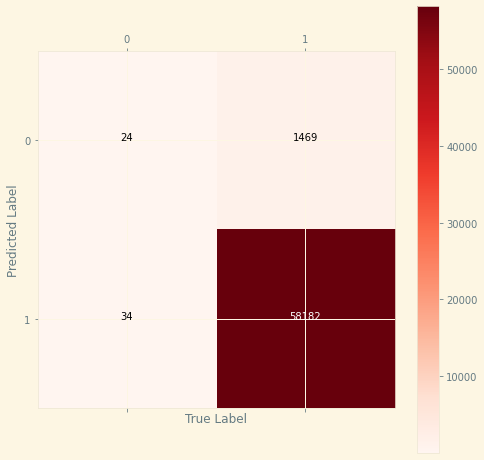

In [148]:
plot_confusion_matrix(xgb_test_result1)

## Version2

### Self define Loss Function: Focal Loss

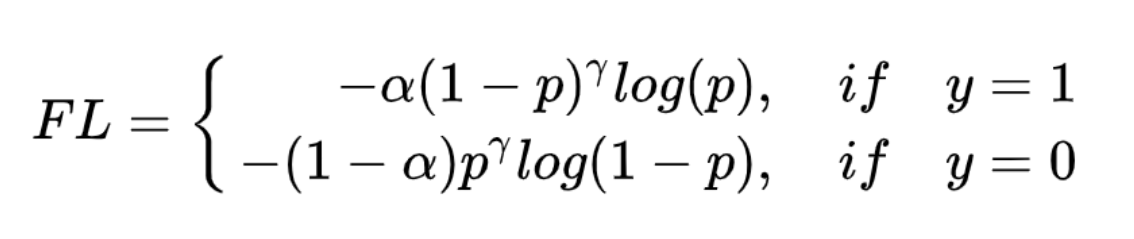

In [49]:
def focal_loss(p, dtrain, alpha=0.03, gamma=0.1):
    y = dtrain.get_label()
    p = 1.0 / (1.0 + np.exp(-p))
    grad = p * (1 - p) * (alpha * gamma * y * (1 - p) ** gamma * np.log(p) / (1 - p) - alpha * y * (
                1 - p) ** gamma / p - gamma * p ** gamma * (1 - alpha) * (1 - y) * np.log(1 - p) / p + p ** gamma * (
                                      1 - alpha) * (1 - y) / (1 - p))
    hess = p * (1 - p) * (p * (1 - p) * (
                -alpha * gamma ** 2 * y * (1 - p) ** gamma * np.log(p) / (1 - p) ** 2 + alpha * gamma * y * (
                    1 - p) ** gamma * np.log(p) / (1 - p) ** 2 + 2 * alpha * gamma * y * (1 - p) ** gamma / (
                            p * (1 - p)) + alpha * y * (1 - p) ** gamma / p ** 2 - gamma ** 2 * p ** gamma * (
                            1 - alpha) * (1 - y) * np.log(1 - p) / p ** 2 + 2 * gamma * p ** gamma * (1 - alpha) * (
                            1 - y) / (p * (1 - p)) + gamma * p ** gamma * (1 - alpha) * (1 - y) * np.log(
            1 - p) / p ** 2 + p ** gamma * (1 - alpha) * (1 - y) / (1 - p) ** 2) - p * (
                                      alpha * gamma * y * (1 - p) ** gamma * np.log(p) / (1 - p) - alpha * y * (
                                          1 - p) ** gamma / p - gamma * p ** gamma * (1 - alpha) * (1 - y) * np.log(
                                  1 - p) / p + p ** gamma * (1 - alpha) * (1 - y) / (1 - p)) + (1 - p) * (
                                      alpha * gamma * y * (1 - p) ** gamma * np.log(p) / (1 - p) - alpha * y * (
                                          1 - p) ** gamma / p - gamma * p ** gamma * (1 - alpha) * (1 - y) * np.log(
                                  1 - p) / p + p ** gamma * (1 - alpha) * (1 - y) / (1 - p)))
    return grad, hess



### Self define Metric Function

In [119]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()] # sort by y_pred ascending
    weights    = np.where(labels[:,0]==0, 32, 1) # weight 20 for label 0 (upsample 20 times)
    cut_vals   = labels[np.cumsum(weights) <= int(0.05 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 32, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)


def amex_metric(preds,dtrain):
    y_true = dtrain.get_label()
    y_pred = preds 
    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()] # sort by y_pred ascending
    weights    = np.where(labels[:,0]==0, 32, 1) # weight 32 for label 0 (upsample 20 times)
    cut_vals   = labels[np.cumsum(weights) <= int(0.05 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 32, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 'amex_metric',0.5 * (gini[1]/gini[0] + top_four)


### Search Parameters in valid set: Optuna

In [331]:
import optuna


# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'random_state': 42,
#         'eval_metric':['auc', amex_metric]
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    kf_iter = 0 
    for train_idx, valid_idx in tqdm(kf.split(train_val_x)):
        kf_iter += 1
        X_train, X_valid = train_val_x[train_idx], train_val_x[valid_idx]
        y_train, y_valid = train_val_y[train_idx], train_val_y[valid_idx]
        dtrain = xgb.DMatrix(data=X_train,label=y_train)
        dval = xgb.DMatrix(data=X_valid,label=y_valid)

        watch_list = [(dtrain, 'train'), (dval, 'valid')]

        xgb_model = xgb.train(params=params, 
                              dtrain=dtrain, 
                              num_boost_round=100, 
                              early_stopping_rounds=20,
                              verbose_eval=20,
                              evals=watch_list,
                              obj = focal_loss,
                              feval = amex_metric
                             )
        if kf_iter>=1:
            break
            
    prob_pred_xgb = xgb_model.predict(dval) # pred probability
    y_pred_xgb = np.array([1 if x > 0.5 else 0 for x in prob_pred_xgb]) # pred value 0,1
    
    # Compute the AUC score
    auc_score = roc_auc_score(y_valid, y_pred_xgb)
    
    amex_score = amex_metric_mod(y_valid,prob_pred_xgb)
    
    # Return the AUC score as the objective value for Optuna
    return amex_score

# Define the study for Optuna
study = optuna.create_study(direction='maximize')

# Optimize the hyperparameters with Optuna
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and the corresponding AUC score
print('Best hyperparameters: ', study.best_params)
print('Best auc score: ', study.best_value)

[I 2023-04-19 01:03:23,543] A new study created in memory with name: no-name-bef4b377-bebf-4b07-9883-92e302af478c
0it [00:00, ?it/s]

[0]	train-auc:0.55541	train-amex_metric:0.07068	valid-auc:0.55963	valid-amex_metric:0.07383
[20]	train-auc:0.68733	train-amex_metric:0.19497	valid-auc:0.67226	valid-amex_metric:0.18184


0it [00:03, ?it/s]
[I 2023-04-19 01:03:27,010] Trial 0 finished with value: 0.5709273839660665 and parameters: {'max_depth': 2, 'eta': 0.049446376965971546, 'min_child_weight': 2, 'subsample': 0.8248641453073366, 'colsample_bytree': 0.20892797043024325, 'lambda': 0.026073232184600503, 'alpha': 0.0001852816581742679}. Best is trial 0 with value: 0.5709273839660665.
0it [00:00, ?it/s]

[0]	train-auc:0.70163	train-amex_metric:0.20614	valid-auc:0.67946	valid-amex_metric:0.18589
[20]	train-auc:0.74870	train-amex_metric:0.25159	valid-auc:0.72815	valid-amex_metric:0.23375


0it [00:04, ?it/s]
[I 2023-04-19 01:03:31,524] Trial 1 finished with value: 0.6238526210208535 and parameters: {'max_depth': 10, 'eta': 2.7242497735365986e-05, 'min_child_weight': 9, 'subsample': 0.38007082080160626, 'colsample_bytree': 0.7506543756418146, 'lambda': 8.516262759487751e-06, 'alpha': 6.97180772419201e-06}. Best is trial 1 with value: 0.6238526210208535.
0it [00:00, ?it/s]

[0]	train-auc:0.70894	train-amex_metric:0.21320	valid-auc:0.68837	valid-amex_metric:0.19460
[20]	train-auc:0.75272	train-amex_metric:0.25587	valid-auc:0.73134	valid-amex_metric:0.23724


0it [00:04, ?it/s]
[I 2023-04-19 01:03:36,067] Trial 2 finished with value: 0.6258447828224558 and parameters: {'max_depth': 7, 'eta': 1.5884680947146464e-05, 'min_child_weight': 6, 'subsample': 0.7479511235154203, 'colsample_bytree': 0.7067249342748282, 'lambda': 0.002977929679795028, 'alpha': 0.3544108127618948}. Best is trial 2 with value: 0.6258447828224558.
0it [00:00, ?it/s]

[0]	train-auc:0.68741	train-amex_metric:0.19181	valid-auc:0.67411	valid-amex_metric:0.18651
[19]	train-auc:0.74155	train-amex_metric:0.24551	valid-auc:0.72761	valid-amex_metric:0.23265


0it [00:03, ?it/s]
[I 2023-04-19 01:03:40,084] Trial 3 finished with value: 0.6051297303541417 and parameters: {'max_depth': 4, 'eta': 8.93382653202655e-07, 'min_child_weight': 5, 'subsample': 0.7303001524335848, 'colsample_bytree': 0.570405096970975, 'lambda': 4.7970819821079644e-05, 'alpha': 3.563876291843152e-08}. Best is trial 2 with value: 0.6258447828224558.
0it [00:00, ?it/s]

[0]	train-auc:0.70481	train-amex_metric:0.20870	valid-auc:0.68448	valid-amex_metric:0.18878
[19]	train-auc:0.75008	train-amex_metric:0.25326	valid-auc:0.73056	valid-amex_metric:0.23610


0it [00:04, ?it/s]
[I 2023-04-19 01:03:44,489] Trial 4 finished with value: 0.6273767110840633 and parameters: {'max_depth': 7, 'eta': 0.00020432502374295112, 'min_child_weight': 6, 'subsample': 0.40531050926625467, 'colsample_bytree': 0.7079005123298309, 'lambda': 2.0931312591384647e-08, 'alpha': 0.05853224980748922}. Best is trial 4 with value: 0.6273767110840633.
0it [00:00, ?it/s]

[0]	train-auc:0.62623	train-amex_metric:0.14203	valid-auc:0.60995	valid-amex_metric:0.12667
[20]	train-auc:0.73859	train-amex_metric:0.24320	valid-auc:0.71190	valid-amex_metric:0.21988


0it [00:04, ?it/s]
[I 2023-04-19 01:03:48,728] Trial 5 finished with value: 0.5949879341895622 and parameters: {'max_depth': 8, 'eta': 7.707248985910583e-05, 'min_child_weight': 4, 'subsample': 0.2561513954704816, 'colsample_bytree': 0.3052952099196976, 'lambda': 2.7604077832997004e-07, 'alpha': 6.114612179101757e-08}. Best is trial 4 with value: 0.6273767110840633.
0it [00:00, ?it/s]

[0]	train-auc:0.63697	train-amex_metric:0.14302	valid-auc:0.62336	valid-amex_metric:0.13503
[19]	train-auc:0.73764	train-amex_metric:0.24156	valid-auc:0.72314	valid-amex_metric:0.22874


0it [00:03, ?it/s]
[I 2023-04-19 01:03:52,413] Trial 6 finished with value: 0.6233171962803776 and parameters: {'max_depth': 2, 'eta': 0.18511346722948424, 'min_child_weight': 5, 'subsample': 0.334525454980145, 'colsample_bytree': 0.6331196427546745, 'lambda': 0.0005091272471525123, 'alpha': 3.3189199736537866e-05}. Best is trial 4 with value: 0.6273767110840633.
0it [00:00, ?it/s]

[0]	train-auc:0.69709	train-amex_metric:0.20157	valid-auc:0.67788	valid-amex_metric:0.18214
[20]	train-auc:0.75058	train-amex_metric:0.25526	valid-auc:0.71565	valid-amex_metric:0.22201


0it [00:04, ?it/s]
[I 2023-04-19 01:03:56,663] Trial 7 finished with value: 0.6182430757180671 and parameters: {'max_depth': 6, 'eta': 0.9228563735495992, 'min_child_weight': 8, 'subsample': 0.32854160216577555, 'colsample_bytree': 0.6793890538815407, 'lambda': 0.0003885859351679574, 'alpha': 0.06730194353372287}. Best is trial 4 with value: 0.6273767110840633.
0it [00:00, ?it/s]

[0]	train-auc:0.69602	train-amex_metric:0.20077	valid-auc:0.67582	valid-amex_metric:0.18134
[20]	train-auc:0.72549	train-amex_metric:0.22953	valid-auc:0.71683	valid-amex_metric:0.22186
[21]	train-auc:0.72506	train-amex_metric:0.22928	valid-auc:0.71559	valid-amex_metric:0.22109


0it [00:03, ?it/s]
[I 2023-04-19 01:04:00,603] Trial 8 finished with value: 0.6039109637574892 and parameters: {'max_depth': 4, 'eta': 7.181048079054065e-05, 'min_child_weight': 8, 'subsample': 0.1356218994123926, 'colsample_bytree': 0.44103388340698657, 'lambda': 6.046329785284099e-06, 'alpha': 0.0062989971163976465}. Best is trial 4 with value: 0.6273767110840633.
0it [00:00, ?it/s]

[0]	train-auc:0.55749	train-amex_metric:0.07231	valid-auc:0.56205	valid-amex_metric:0.07669
[19]	train-auc:0.69913	train-amex_metric:0.20604	valid-auc:0.67690	valid-amex_metric:0.18615


0it [00:03, ?it/s]
[I 2023-04-19 01:04:04,410] Trial 9 finished with value: 0.5771601181646444 and parameters: {'max_depth': 5, 'eta': 0.13493171384999467, 'min_child_weight': 4, 'subsample': 0.8642801621953241, 'colsample_bytree': 0.13146277355365843, 'lambda': 7.047659568770187e-07, 'alpha': 1.048824853520372}. Best is trial 4 with value: 0.6273767110840633.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.21346	valid-auc:0.50000	valid-amex_metric:0.19635
[19]	train-auc:0.70498	train-amex_metric:0.24286	valid-auc:0.69007	valid-amex_metric:0.22637


0it [00:04, ?it/s]
[I 2023-04-19 01:04:08,929] Trial 10 finished with value: 0.6575729337035487 and parameters: {'max_depth': 10, 'eta': 1.2195911918935736e-08, 'min_child_weight': 1, 'subsample': 0.5579143355332323, 'colsample_bytree': 0.9986901542075164, 'lambda': 4.1961535056657775, 'alpha': 7.671115511060968}. Best is trial 10 with value: 0.6575729337035487.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.21321	valid-auc:0.50000	valid-amex_metric:0.19382
[20]	train-auc:0.70539	train-amex_metric:0.24507	valid-auc:0.68931	valid-amex_metric:0.23067


0it [00:04, ?it/s]
[I 2023-04-19 01:04:13,620] Trial 11 finished with value: 0.6568606775730886 and parameters: {'max_depth': 10, 'eta': 1.1720643068464424e-08, 'min_child_weight': 2, 'subsample': 0.5666009555582971, 'colsample_bytree': 0.9872614685923841, 'lambda': 5.278405853633054, 'alpha': 5.668156762074807}. Best is trial 10 with value: 0.6575729337035487.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.21533	valid-auc:0.50000	valid-amex_metric:0.19895
[20]	train-auc:0.70499	train-amex_metric:0.24660	valid-auc:0.68907	valid-amex_metric:0.23080


0it [00:04, ?it/s]
[I 2023-04-19 01:04:18,364] Trial 12 finished with value: 0.6561616635463199 and parameters: {'max_depth': 10, 'eta': 1.0435542604047653e-08, 'min_child_weight': 1, 'subsample': 0.5900731153185551, 'colsample_bytree': 0.9918476961837883, 'lambda': 5.409481980677146, 'alpha': 5.095009122290232}. Best is trial 10 with value: 0.6575729337035487.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.21310	valid-auc:0.50000	valid-amex_metric:0.19164
[20]	train-auc:0.73339	train-amex_metric:0.24335	valid-auc:0.71617	valid-amex_metric:0.22820


0it [00:04, ?it/s]
[I 2023-04-19 01:04:23,007] Trial 13 finished with value: 0.6565366334346213 and parameters: {'max_depth': 9, 'eta': 4.658487561095098e-08, 'min_child_weight': 1, 'subsample': 0.5688929651888552, 'colsample_bytree': 0.9950940786373788, 'lambda': 5.921047677075732, 'alpha': 7.922568810414887}. Best is trial 10 with value: 0.6575729337035487.
0it [00:00, ?it/s]

[0]	train-auc:0.69702	train-amex_metric:0.22795	valid-auc:0.67402	valid-amex_metric:0.19512
[19]	train-auc:0.76586	train-amex_metric:0.26904	valid-auc:0.73160	valid-amex_metric:0.23580


0it [00:04, ?it/s]
[I 2023-04-19 01:04:27,964] Trial 14 finished with value: 0.6594128465310618 and parameters: {'max_depth': 10, 'eta': 1.6731225498407523e-07, 'min_child_weight': 2, 'subsample': 0.504273865575993, 'colsample_bytree': 0.8776807977430708, 'lambda': 0.23335543125342048, 'alpha': 0.0033311046373929528}. Best is trial 14 with value: 0.6594128465310618.
0it [00:00, ?it/s]

[0]	train-auc:0.69008	train-amex_metric:0.21372	valid-auc:0.67179	valid-amex_metric:0.19283
[19]	train-auc:0.75949	train-amex_metric:0.26279	valid-auc:0.73242	valid-amex_metric:0.23739


0it [00:04, ?it/s]
[I 2023-04-19 01:04:32,698] Trial 15 finished with value: 0.658783212675229 and parameters: {'max_depth': 9, 'eta': 2.3542837117083993e-07, 'min_child_weight': 3, 'subsample': 0.48500361382716445, 'colsample_bytree': 0.8507762696855556, 'lambda': 0.17057901044257326, 'alpha': 0.0011844443025695321}. Best is trial 14 with value: 0.6594128465310618.
0it [00:00, ?it/s]

[0]	train-auc:0.69689	train-amex_metric:0.21261	valid-auc:0.67560	valid-amex_metric:0.19215
[19]	train-auc:0.75599	train-amex_metric:0.25877	valid-auc:0.73093	valid-amex_metric:0.23575


0it [00:04, ?it/s]
[I 2023-04-19 01:04:37,333] Trial 16 finished with value: 0.6576363267531348 and parameters: {'max_depth': 8, 'eta': 3.441374312010433e-07, 'min_child_weight': 3, 'subsample': 0.4551956012606797, 'colsample_bytree': 0.8361455566386511, 'lambda': 0.07836314706132945, 'alpha': 0.0027257714034962994}. Best is trial 14 with value: 0.6594128465310618.
0it [00:00, ?it/s]

[0]	train-auc:0.71696	train-amex_metric:0.22159	valid-auc:0.68796	valid-amex_metric:0.19235
[19]	train-auc:0.76557	train-amex_metric:0.26787	valid-auc:0.73166	valid-amex_metric:0.23720


0it [00:05, ?it/s]
[I 2023-04-19 01:04:42,573] Trial 17 finished with value: 0.6241302473596795 and parameters: {'max_depth': 9, 'eta': 1.050332316350161e-06, 'min_child_weight': 3, 'subsample': 0.9794426146484725, 'colsample_bytree': 0.8547776216661666, 'lambda': 0.1685873899648883, 'alpha': 1.6067849863562491e-06}. Best is trial 14 with value: 0.6594128465310618.
0it [00:00, ?it/s]

[0]	train-auc:0.69659	train-amex_metric:0.20179	valid-auc:0.67183	valid-amex_metric:0.17760
[20]	train-auc:0.74936	train-amex_metric:0.25299	valid-auc:0.72969	valid-amex_metric:0.23495


0it [00:04, ?it/s]
[I 2023-04-19 01:04:47,059] Trial 18 finished with value: 0.6239434843919268 and parameters: {'max_depth': 9, 'eta': 0.0017476898472514855, 'min_child_weight': 3, 'subsample': 0.19909164324211254, 'colsample_bytree': 0.8741833933455577, 'lambda': 0.4211477484281331, 'alpha': 0.0014913264018905194}. Best is trial 14 with value: 0.6594128465310618.
0it [00:00, ?it/s]

[0]	train-auc:0.64893	train-amex_metric:0.21176	valid-auc:0.63181	valid-amex_metric:0.19076
[19]	train-auc:0.75030	train-amex_metric:0.26046	valid-auc:0.72622	valid-amex_metric:0.23787


0it [00:04, ?it/s]
[I 2023-04-19 01:04:51,722] Trial 19 finished with value: 0.6604671786007604 and parameters: {'max_depth': 8, 'eta': 1.2604442697609504e-07, 'min_child_weight': 2, 'subsample': 0.4756337806606225, 'colsample_bytree': 0.5016416189720092, 'lambda': 0.010208141554594402, 'alpha': 0.0003971767521919189}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.71125	train-amex_metric:0.21513	valid-auc:0.68114	valid-amex_metric:0.18645
[20]	train-auc:0.76015	train-amex_metric:0.26299	valid-auc:0.72915	valid-amex_metric:0.23462
[21]	train-auc:0.75921	train-amex_metric:0.26175	valid-auc:0.72770	valid-amex_metric:0.23274


0it [00:04, ?it/s]
[I 2023-04-19 01:04:56,606] Trial 20 finished with value: 0.6218364402971304 and parameters: {'max_depth': 8, 'eta': 4.105101809540298e-06, 'min_child_weight': 2, 'subsample': 0.6541711272202743, 'colsample_bytree': 0.48045398141719975, 'lambda': 0.008474168786983705, 'alpha': 0.00012325186394351276}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.57375	train-amex_metric:0.21139	valid-auc:0.56584	valid-amex_metric:0.18564
[20]	train-auc:0.74479	train-amex_metric:0.25969	valid-auc:0.71971	valid-amex_metric:0.23390


0it [00:04, ?it/s]
[I 2023-04-19 01:05:01,250] Trial 21 finished with value: 0.6584402914953293 and parameters: {'max_depth': 9, 'eta': 7.226173599603575e-08, 'min_child_weight': 2, 'subsample': 0.45902254844757817, 'colsample_bytree': 0.37847026047369464, 'lambda': 0.5783193276770956, 'alpha': 0.014180913979734663}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.64945	train-amex_metric:0.21124	valid-auc:0.63513	valid-amex_metric:0.19330
[20]	train-auc:0.74434	train-amex_metric:0.25424	valid-auc:0.72586	valid-amex_metric:0.23583


0it [00:04, ?it/s]
[I 2023-04-19 01:05:05,769] Trial 22 finished with value: 0.6578767977212311 and parameters: {'max_depth': 7, 'eta': 1.2169211280774254e-07, 'min_child_weight': 4, 'subsample': 0.4797419043841372, 'colsample_bytree': 0.5732745223290855, 'lambda': 0.002979167935581114, 'alpha': 0.000843470831475254}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.71333	train-amex_metric:0.21733	valid-auc:0.68331	valid-amex_metric:0.18990
[20]	train-auc:0.76376	train-amex_metric:0.26606	valid-auc:0.73223	valid-amex_metric:0.23706


0it [00:04, ?it/s]
[I 2023-04-19 01:05:10,699] Trial 23 finished with value: 0.658462619936128 and parameters: {'max_depth': 8, 'eta': 2.339649401047736e-06, 'min_child_weight': 1, 'subsample': 0.6677982816449582, 'colsample_bytree': 0.7923404725233482, 'lambda': 0.02533961056644267, 'alpha': 3.510839319018865e-05}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.70782	train-amex_metric:0.22677	valid-auc:0.68463	valid-amex_metric:0.20401
[20]	train-auc:0.75650	train-amex_metric:0.26014	valid-auc:0.73052	valid-amex_metric:0.23514


0it [00:04, ?it/s]
[I 2023-04-19 01:05:15,525] Trial 24 finished with value: 0.658408101913484 and parameters: {'max_depth': 9, 'eta': 2.5621173002166405e-07, 'min_child_weight': 3, 'subsample': 0.4856386840065475, 'colsample_bytree': 0.9120269996077716, 'lambda': 0.8889380434662615, 'alpha': 0.018421847483029382}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20057	valid-auc:0.50000	valid-amex_metric:0.18138
[20]	train-auc:0.73309	train-amex_metric:0.24995	valid-auc:0.71408	valid-amex_metric:0.23173


0it [00:03, ?it/s]
[I 2023-04-19 01:05:19,513] Trial 25 finished with value: 0.6580643707112841 and parameters: {'max_depth': 6, 'eta': 3.9933587786233574e-08, 'min_child_weight': 2, 'subsample': 0.28184080326511063, 'colsample_bytree': 0.4965775063003322, 'lambda': 0.06198201226703608, 'alpha': 0.00041564850809747774}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.72329	train-amex_metric:0.22647	valid-auc:0.69951	valid-amex_metric:0.20403
[19]	train-auc:0.75610	train-amex_metric:0.25861	valid-auc:0.72981	valid-amex_metric:0.23478


0it [00:04, ?it/s]
[I 2023-04-19 01:05:24,416] Trial 26 finished with value: 0.6243731836130375 and parameters: {'max_depth': 10, 'eta': 4.200265414031714e-06, 'min_child_weight': 4, 'subsample': 0.409514251255785, 'colsample_bytree': 0.9131841664589703, 'lambda': 0.002525111546523627, 'alpha': 1.216737653248656e-06}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.61461	train-amex_metric:0.14721	valid-auc:0.59681	valid-amex_metric:0.13011
[20]	train-auc:0.74732	train-amex_metric:0.25212	valid-auc:0.71649	valid-amex_metric:0.22328


0it [00:04, ?it/s]
[I 2023-04-19 01:05:28,788] Trial 27 finished with value: 0.6140660724624819 and parameters: {'max_depth': 8, 'eta': 3.04226479548285e-07, 'min_child_weight': 3, 'subsample': 0.6242593453835301, 'colsample_bytree': 0.34412369842336876, 'lambda': 1.0226723270535512, 'alpha': 4.561143952815896e-05}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.70647	train-amex_metric:0.20987	valid-auc:0.68092	valid-amex_metric:0.18529
[19]	train-auc:0.75627	train-amex_metric:0.25885	valid-auc:0.73036	valid-amex_metric:0.23556


0it [00:04, ?it/s]
[I 2023-04-19 01:05:33,857] Trial 28 finished with value: 0.6252283558519532 and parameters: {'max_depth': 7, 'eta': 0.0011190251031261585, 'min_child_weight': 1, 'subsample': 0.5173337769505294, 'colsample_bytree': 0.6191185677282486, 'lambda': 0.013135018304427483, 'alpha': 0.003454040116492657}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.07196	valid-auc:0.50000	valid-amex_metric:0.07794
[19]	train-auc:0.65848	train-amex_metric:0.21197	valid-auc:0.63290	valid-amex_metric:0.17567


0it [00:04, ?it/s]
[I 2023-04-19 01:05:38,408] Trial 29 finished with value: 0.6225938463662399 and parameters: {'max_depth': 9, 'eta': 3.237371613562607e-08, 'min_child_weight': 2, 'subsample': 0.70203952160142, 'colsample_bytree': 0.22108429813574754, 'lambda': 0.2116208178752801, 'alpha': 0.0002708843887462384}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.71579	train-amex_metric:0.22195	valid-auc:0.69044	valid-amex_metric:0.19555
[20]	train-auc:0.76241	train-amex_metric:0.26483	valid-auc:0.73213	valid-amex_metric:0.23710


0it [00:05, ?it/s]
[I 2023-04-19 01:05:43,935] Trial 30 finished with value: 0.6272246734201395 and parameters: {'max_depth': 10, 'eta': 1.2022364700739885e-05, 'min_child_weight': 5, 'subsample': 0.8083143128997676, 'colsample_bytree': 0.7553361948024155, 'lambda': 0.041480731635447826, 'alpha': 0.12030803912859282}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.71405	train-amex_metric:0.21815	valid-auc:0.68729	valid-amex_metric:0.19274
[20]	train-auc:0.76337	train-amex_metric:0.26578	valid-auc:0.73262	valid-amex_metric:0.23783


0it [00:04, ?it/s]
[I 2023-04-19 01:05:48,928] Trial 31 finished with value: 0.6257274352439999 and parameters: {'max_depth': 8, 'eta': 1.506180410996389e-06, 'min_child_weight': 1, 'subsample': 0.6610640736790818, 'colsample_bytree': 0.7980187618786321, 'lambda': 0.018007296040602895, 'alpha': 2.035968217870024e-05}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.70987	train-amex_metric:0.21330	valid-auc:0.68017	valid-amex_metric:0.18626
[19]	train-auc:0.76306	train-amex_metric:0.26538	valid-auc:0.73399	valid-amex_metric:0.23932


0it [00:04, ?it/s]
[I 2023-04-19 01:05:53,851] Trial 32 finished with value: 0.6268908385773473 and parameters: {'max_depth': 8, 'eta': 3.1367171491992605e-06, 'min_child_weight': 1, 'subsample': 0.5260729031639039, 'colsample_bytree': 0.7752637279866275, 'lambda': 0.005228968979853043, 'alpha': 2.691904329915909e-06}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.69166	train-amex_metric:0.21587	valid-auc:0.67332	valid-amex_metric:0.20079
[20]	train-auc:0.75169	train-amex_metric:0.25455	valid-auc:0.72954	valid-amex_metric:0.23454


0it [00:04, ?it/s]
[I 2023-04-19 01:05:58,402] Trial 33 finished with value: 0.6576743978012474 and parameters: {'max_depth': 7, 'eta': 1.6056140573828336e-07, 'min_child_weight': 2, 'subsample': 0.37163163361360185, 'colsample_bytree': 0.931724165451297, 'lambda': 0.0009807688489573295, 'alpha': 6.774305283488899e-05}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.70907	train-amex_metric:0.22058	valid-auc:0.68287	valid-amex_metric:0.19490
[20]	train-auc:0.76326	train-amex_metric:0.26582	valid-auc:0.73170	valid-amex_metric:0.23687


0it [00:04, ?it/s]
[I 2023-04-19 01:06:03,478] Trial 34 finished with value: 0.6577453980167837 and parameters: {'max_depth': 9, 'eta': 5.786440092396085e-07, 'min_child_weight': 3, 'subsample': 0.8010830858303601, 'colsample_bytree': 0.8206235221493303, 'lambda': 0.02804742161382991, 'alpha': 6.5915422282124145e-06}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.71370	train-amex_metric:0.21898	valid-auc:0.68620	valid-amex_metric:0.19365
[20]	train-auc:0.76049	train-amex_metric:0.26385	valid-auc:0.73478	valid-amex_metric:0.24045


0it [00:04, ?it/s]
[I 2023-04-19 01:06:08,399] Trial 35 finished with value: 0.6292085589069347 and parameters: {'max_depth': 10, 'eta': 1.860095236516748e-06, 'min_child_weight': 2, 'subsample': 0.6215276733912352, 'colsample_bytree': 0.6817918533502713, 'lambda': 1.9037007297657347, 'alpha': 4.1872824834687173e-07}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.70473	train-amex_metric:0.20908	valid-auc:0.68128	valid-amex_metric:0.18695
[20]	train-auc:0.76138	train-amex_metric:0.26351	valid-auc:0.73242	valid-amex_metric:0.23791


0it [00:04, ?it/s]
[I 2023-04-19 01:06:13,057] Trial 36 finished with value: 0.6258604549930479 and parameters: {'max_depth': 8, 'eta': 9.232184241953902e-06, 'min_child_weight': 1, 'subsample': 0.4245067972213163, 'colsample_bytree': 0.7307391334821965, 'lambda': 0.23281917557217766, 'alpha': 0.0006671243591273964}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.70853	train-amex_metric:0.21322	valid-auc:0.68860	valid-amex_metric:0.19201
[20]	train-auc:0.75101	train-amex_metric:0.25436	valid-auc:0.73155	valid-amex_metric:0.23580


0it [00:04, ?it/s]
[I 2023-04-19 01:06:17,710] Trial 37 finished with value: 0.6257786779590819 and parameters: {'max_depth': 7, 'eta': 3.5871402308204074e-05, 'min_child_weight': 7, 'subsample': 0.704410835449, 'colsample_bytree': 0.5385580621881508, 'lambda': 0.00017041586215999554, 'alpha': 0.0002504277238732764}. Best is trial 19 with value: 0.6604671786007604.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20563	valid-auc:0.50000	valid-amex_metric:0.19248
[20]	train-auc:0.73125	train-amex_metric:0.25142	valid-auc:0.71509	valid-amex_metric:0.23789


0it [00:04, ?it/s]
[I 2023-04-19 01:06:22,017] Trial 38 finished with value: 0.6614299429321681 and parameters: {'max_depth': 6, 'eta': 2.1500485485903008e-08, 'min_child_weight': 10, 'subsample': 0.7555819181541142, 'colsample_bytree': 0.6314833501417163, 'lambda': 0.08128015003118196, 'alpha': 1.2419149054853952e-05}. Best is trial 38 with value: 0.6614299429321681.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20131	valid-auc:0.50000	valid-amex_metric:0.18574
[20]	train-auc:0.72188	train-amex_metric:0.24992	valid-auc:0.70657	valid-amex_metric:0.23554


0it [00:03, ?it/s]
[I 2023-04-19 01:06:26,103] Trial 39 finished with value: 0.6602376253245372 and parameters: {'max_depth': 5, 'eta': 2.4379965120540643e-08, 'min_child_weight': 10, 'subsample': 0.9519652409032429, 'colsample_bytree': 0.4163702871609531, 'lambda': 0.0013471928658267023, 'alpha': 9.471906729463398e-06}. Best is trial 38 with value: 0.6614299429321681.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20185	valid-auc:0.50000	valid-amex_metric:0.18537
[19]	train-auc:0.72719	train-amex_metric:0.24981	valid-auc:0.71215	valid-amex_metric:0.23561


0it [00:03, ?it/s]
[I 2023-04-19 01:06:30,227] Trial 40 finished with value: 0.661957091357837 and parameters: {'max_depth': 5, 'eta': 3.148306405458881e-08, 'min_child_weight': 10, 'subsample': 0.9286502352428996, 'colsample_bytree': 0.4059417932316075, 'lambda': 0.00010576882545537816, 'alpha': 3.163309311694438e-07}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20148	valid-auc:0.50000	valid-amex_metric:0.18674
[20]	train-auc:0.72155	train-amex_metric:0.25063	valid-auc:0.70651	valid-amex_metric:0.23406


0it [00:03, ?it/s]
[I 2023-04-19 01:06:34,335] Trial 41 finished with value: 0.6590064618648546 and parameters: {'max_depth': 5, 'eta': 2.4985798959408687e-08, 'min_child_weight': 10, 'subsample': 0.9914044924891079, 'colsample_bytree': 0.40771198318189916, 'lambda': 7.908444334289548e-05, 'alpha': 2.3162339889625932e-07}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.14298	valid-auc:0.50000	valid-amex_metric:0.12830
[20]	train-auc:0.62529	train-amex_metric:0.24299	valid-auc:0.61772	valid-amex_metric:0.22386


0it [00:03, ?it/s]
[I 2023-04-19 01:06:38,131] Trial 42 finished with value: 0.6136698306842082 and parameters: {'max_depth': 4, 'eta': 1.0073085239749659e-08, 'min_child_weight': 10, 'subsample': 0.9249557094380879, 'colsample_bytree': 0.26059913980669147, 'lambda': 4.6487345853979194e-05, 'alpha': 1.0658470830235062e-05}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.56803	train-amex_metric:0.20201	valid-auc:0.55986	valid-amex_metric:0.18701
[20]	train-auc:0.74549	train-amex_metric:0.25074	valid-auc:0.72761	valid-amex_metric:0.23514


0it [00:04, ?it/s]
[I 2023-04-19 01:06:42,421] Trial 43 finished with value: 0.6238542762838148 and parameters: {'max_depth': 5, 'eta': 9.319986175882225e-08, 'min_child_weight': 10, 'subsample': 0.8935344313633311, 'colsample_bytree': 0.4234288574861599, 'lambda': 1.8627321795205083e-05, 'alpha': 1.6757714672463512e-07}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.13375	valid-auc:0.50000	valid-amex_metric:0.13153
[20]	train-auc:0.63658	train-amex_metric:0.23415	valid-auc:0.62821	valid-amex_metric:0.21865


0it [00:03, ?it/s]
[I 2023-04-19 01:06:46,124] Trial 44 finished with value: 0.6226117372935677 and parameters: {'max_depth': 3, 'eta': 1.1849390529740147e-08, 'min_child_weight': 9, 'subsample': 0.9393317315523606, 'colsample_bytree': 0.32232133200517166, 'lambda': 0.0013293634867461526, 'alpha': 2.5014693114563774e-08}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20570	valid-auc:0.50000	valid-amex_metric:0.19323
[20]	train-auc:0.72959	train-amex_metric:0.25173	valid-auc:0.71071	valid-amex_metric:0.23536


0it [00:04, ?it/s]
[I 2023-04-19 01:06:50,464] Trial 45 finished with value: 0.6593155029815865 and parameters: {'max_depth': 6, 'eta': 2.3656546062631673e-08, 'min_child_weight': 9, 'subsample': 0.787335368069593, 'colsample_bytree': 0.5429481092332635, 'lambda': 0.00029879195858564133, 'alpha': 4.535369401371012e-06}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.54026	train-amex_metric:0.19637	valid-auc:0.53932	valid-amex_metric:0.18316
[20]	train-auc:0.73135	train-amex_metric:0.24516	valid-auc:0.71655	valid-amex_metric:0.23355


0it [00:03, ?it/s]
[I 2023-04-19 01:06:54,605] Trial 46 finished with value: 0.6571728179055781 and parameters: {'max_depth': 4, 'eta': 6.854370696183455e-08, 'min_child_weight': 9, 'subsample': 0.8492057507546148, 'colsample_bytree': 0.47717743770157384, 'lambda': 2.0203138809981363e-06, 'alpha': 4.861035863665481e-07}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.62184	train-amex_metric:0.14334	valid-auc:0.61210	valid-amex_metric:0.12916
[20]	train-auc:0.74007	train-amex_metric:0.24524	valid-auc:0.71737	valid-amex_metric:0.22492


0it [00:03, ?it/s]
[I 2023-04-19 01:06:58,730] Trial 47 finished with value: 0.5987136845871774 and parameters: {'max_depth': 5, 'eta': 5.678352803148219e-07, 'min_child_weight': 8, 'subsample': 0.7583084455552596, 'colsample_bytree': 0.3652916734271722, 'lambda': 0.0012751317690797362, 'alpha': 7.129571560062886e-08}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.13382	valid-auc:0.50000	valid-amex_metric:0.13283
[20]	train-auc:0.66998	train-amex_metric:0.23396	valid-auc:0.66291	valid-amex_metric:0.22049


0it [00:03, ?it/s]
[I 2023-04-19 01:07:02,417] Trial 48 finished with value: 0.6463645494796838 and parameters: {'max_depth': 3, 'eta': 1.917277457667691e-08, 'min_child_weight': 10, 'subsample': 0.9281158322458238, 'colsample_bytree': 0.2785614436917909, 'lambda': 0.0001373857858063785, 'alpha': 1.3076388114879153e-08}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.07116	valid-auc:0.50000	valid-amex_metric:0.07515
[20]	train-auc:0.67998	train-amex_metric:0.19699	valid-auc:0.66110	valid-amex_metric:0.17823


0it [00:03, ?it/s]
[I 2023-04-19 01:07:06,070] Trial 49 finished with value: 0.5516229325061244 and parameters: {'max_depth': 5, 'eta': 1.0212102564239635e-07, 'min_child_weight': 7, 'subsample': 0.3579853567265138, 'colsample_bytree': 0.14043796597540575, 'lambda': 0.0005245784943776074, 'alpha': 1.479304994841749e-05}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20706	valid-auc:0.50000	valid-amex_metric:0.19499
[20]	train-auc:0.68507	train-amex_metric:0.25233	valid-auc:0.67003	valid-amex_metric:0.23476


0it [00:04, ?it/s]
[I 2023-04-19 01:07:10,433] Trial 50 finished with value: 0.6484559214038884 and parameters: {'max_depth': 6, 'eta': 1.0046004748345765e-08, 'min_child_weight': 6, 'subsample': 0.8841432307696714, 'colsample_bytree': 0.6129167905612785, 'lambda': 0.007339605996795913, 'alpha': 9.355130116971143e-05}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20575	valid-auc:0.50000	valid-amex_metric:0.19303
[19]	train-auc:0.73014	train-amex_metric:0.25127	valid-auc:0.71337	valid-amex_metric:0.23386


0it [00:04, ?it/s]
[I 2023-04-19 01:07:14,753] Trial 51 finished with value: 0.6582297561339819 and parameters: {'max_depth': 6, 'eta': 2.654754133868258e-08, 'min_child_weight': 9, 'subsample': 0.7838635482755378, 'colsample_bytree': 0.5292415139143443, 'lambda': 2.0130277709043345e-05, 'alpha': 2.852423973739823e-06}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.19911	valid-auc:0.50000	valid-amex_metric:0.19036
[19]	train-auc:0.73448	train-amex_metric:0.24802	valid-auc:0.72062	valid-amex_metric:0.23461


0it [00:04, ?it/s]
[I 2023-04-19 01:07:19,214] Trial 52 finished with value: 0.6592807424593968 and parameters: {'max_depth': 5, 'eta': 5.032932605778168e-08, 'min_child_weight': 9, 'subsample': 0.847302440818746, 'colsample_bytree': 0.5862118741403912, 'lambda': 0.0002996023399520055, 'alpha': 7.00458586009467e-06}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.21076	valid-auc:0.50000	valid-amex_metric:0.19062
[20]	train-auc:0.71593	train-amex_metric:0.25246	valid-auc:0.69960	valid-amex_metric:0.23654


0it [00:04, ?it/s]
[I 2023-04-19 01:07:23,423] Trial 53 finished with value: 0.6589197542603651 and parameters: {'max_depth': 6, 'eta': 1.7615359413780483e-08, 'min_child_weight': 10, 'subsample': 0.9801709591512107, 'colsample_bytree': 0.4681153361535654, 'lambda': 0.0032219523037197878, 'alpha': 3.883794051575682e-06}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.67532	train-amex_metric:0.19640	valid-auc:0.66148	valid-amex_metric:0.18320
[20]	train-auc:0.73520	train-amex_metric:0.24529	valid-auc:0.72199	valid-amex_metric:0.23166


0it [00:04, ?it/s]
[I 2023-04-19 01:07:27,653] Trial 54 finished with value: 0.6062460819573521 and parameters: {'max_depth': 4, 'eta': 1.57996762123489e-07, 'min_child_weight': 9, 'subsample': 0.7509897090694498, 'colsample_bytree': 0.39609666795441556, 'lambda': 0.07606831859652942, 'alpha': 8.518433909504995e-07}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.70002	train-amex_metric:0.21159	valid-auc:0.68287	valid-amex_metric:0.19394
[19]	train-auc:0.74917	train-amex_metric:0.25243	valid-auc:0.73002	valid-amex_metric:0.23416


0it [00:04, ?it/s]
[I 2023-04-19 01:07:31,996] Trial 55 finished with value: 0.6233799553994678 and parameters: {'max_depth': 6, 'eta': 4.840661846717371e-07, 'min_child_weight': 8, 'subsample': 0.956252008747043, 'colsample_bytree': 0.4387656221297158, 'lambda': 0.0005162826712018813, 'alpha': 0.007040113283528611}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.54529	train-amex_metric:0.19979	valid-auc:0.53982	valid-amex_metric:0.18457
[20]	train-auc:0.73545	train-amex_metric:0.24868	valid-auc:0.72283	valid-amex_metric:0.23491


0it [00:04, ?it/s]
[I 2023-04-19 01:07:36,166] Trial 56 finished with value: 0.6605531818380322 and parameters: {'max_depth': 5, 'eta': 6.169910390015637e-08, 'min_child_weight': 10, 'subsample': 0.5920490540972029, 'colsample_bytree': 0.516263715279629, 'lambda': 5.337054040376878e-05, 'alpha': 0.0001353069004723069}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.54529	train-amex_metric:0.19983	valid-auc:0.53982	valid-amex_metric:0.18486
[19]	train-auc:0.73416	train-amex_metric:0.24861	valid-auc:0.72127	valid-amex_metric:0.23531


0it [00:04, ?it/s]
[I 2023-04-19 01:07:40,335] Trial 57 finished with value: 0.660306125036451 and parameters: {'max_depth': 5, 'eta': 5.762846364907527e-08, 'min_child_weight': 10, 'subsample': 0.5875930706309307, 'colsample_bytree': 0.507320987431066, 'lambda': 1.817299312136363e-05, 'alpha': 0.00019497275809754905}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.19458	valid-auc:0.50000	valid-amex_metric:0.18348
[20]	train-auc:0.72850	train-amex_metric:0.24557	valid-auc:0.71637	valid-amex_metric:0.23562


0it [00:03, ?it/s]
[I 2023-04-19 01:07:44,459] Trial 58 finished with value: 0.6609018788291163 and parameters: {'max_depth': 4, 'eta': 4.5042061645826806e-08, 'min_child_weight': 10, 'subsample': 0.5829292657267009, 'colsample_bytree': 0.4999052668213774, 'lambda': 2.5210190337921477e-06, 'alpha': 2.1055830861082925e-05}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.18807	valid-auc:0.50000	valid-amex_metric:0.18043
[20]	train-auc:0.72079	train-amex_metric:0.23186	valid-auc:0.70943	valid-amex_metric:0.22519


0it [00:03, ?it/s]
[I 2023-04-19 01:07:48,256] Trial 59 finished with value: 0.6563770942598298 and parameters: {'max_depth': 3, 'eta': 6.161836879089176e-08, 'min_child_weight': 10, 'subsample': 0.57018066103755, 'colsample_bytree': 0.51030966162059, 'lambda': 1.9167628540177497e-07, 'alpha': 0.00015628282316374067}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.68995	train-amex_metric:0.19444	valid-auc:0.67442	valid-amex_metric:0.18422
[19]	train-auc:0.74084	train-amex_metric:0.24416	valid-auc:0.72575	valid-amex_metric:0.23115


0it [00:04, ?it/s]
[I 2023-04-19 01:07:52,435] Trial 60 finished with value: 0.6237914819463639 and parameters: {'max_depth': 4, 'eta': 0.013757257770331589, 'min_child_weight': 10, 'subsample': 0.6177262589099173, 'colsample_bytree': 0.646425475839443, 'lambda': 2.582735895876918e-06, 'alpha': 3.2344795125310714e-05}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.54529	train-amex_metric:0.19931	valid-auc:0.53982	valid-amex_metric:0.18531
[20]	train-auc:0.73497	train-amex_metric:0.24936	valid-auc:0.72084	valid-amex_metric:0.23638
[21]	train-auc:0.73471	train-amex_metric:0.24842	valid-auc:0.71949	valid-amex_metric:0.23533


0it [00:04, ?it/s]
[I 2023-04-19 01:07:56,713] Trial 61 finished with value: 0.659183152381395 and parameters: {'max_depth': 5, 'eta': 6.411159910482411e-08, 'min_child_weight': 10, 'subsample': 0.5391257866303902, 'colsample_bytree': 0.4622802976465169, 'lambda': 4.027187169523625e-06, 'alpha': 0.00046893602784642865}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.19461	valid-auc:0.50000	valid-amex_metric:0.18414
[20]	train-auc:0.72735	train-amex_metric:0.24551	valid-auc:0.71528	valid-amex_metric:0.23512


0it [00:03, ?it/s]
[I 2023-04-19 01:08:00,647] Trial 62 finished with value: 0.6590642551950604 and parameters: {'max_depth': 4, 'eta': 3.9028822068969507e-08, 'min_child_weight': 10, 'subsample': 0.5909211898529109, 'colsample_bytree': 0.5713881311636425, 'lambda': 1.2424062129253543e-05, 'alpha': 8.583191485222219e-05}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.67286	train-amex_metric:0.20157	valid-auc:0.66155	valid-amex_metric:0.18267
[20]	train-auc:0.74340	train-amex_metric:0.24857	valid-auc:0.72903	valid-amex_metric:0.23532


0it [00:03, ?it/s]
[I 2023-04-19 01:08:04,695] Trial 63 finished with value: 0.626366190655301 and parameters: {'max_depth': 5, 'eta': 1.5975443960122763e-07, 'min_child_weight': 9, 'subsample': 0.4375844046540595, 'colsample_bytree': 0.5087179611862773, 'lambda': 6.870831993814711e-07, 'alpha': 2.1113380576570742e-05}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.19374	valid-auc:0.50000	valid-amex_metric:0.18362
[20]	train-auc:0.69068	train-amex_metric:0.24539	valid-auc:0.67998	valid-amex_metric:0.23179
[21]	train-auc:0.69084	train-amex_metric:0.24486	valid-auc:0.67967	valid-amex_metric:0.23180


0it [00:03, ?it/s]
[I 2023-04-19 01:08:08,741] Trial 64 finished with value: 0.6507859329414234 and parameters: {'max_depth': 4, 'eta': 1.3879920077614658e-08, 'min_child_weight': 10, 'subsample': 0.7047665238034546, 'colsample_bytree': 0.43264895071036746, 'lambda': 2.6155370468760842e-05, 'alpha': 5.9848960368200424e-05}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.68664	train-amex_metric:0.19935	valid-auc:0.66805	valid-amex_metric:0.18446
[20]	train-auc:0.73964	train-amex_metric:0.24949	valid-auc:0.72381	valid-amex_metric:0.23542
[21]	train-auc:0.73932	train-amex_metric:0.24946	valid-auc:0.72298	valid-amex_metric:0.23522


0it [00:04, ?it/s]
[I 2023-04-19 01:08:13,025] Trial 65 finished with value: 0.6075483160692928 and parameters: {'max_depth': 5, 'eta': 2.714025547382634e-07, 'min_child_weight': 9, 'subsample': 0.5481988848661205, 'colsample_bytree': 0.3801239105369264, 'lambda': 4.0842960259382975e-05, 'alpha': 0.0016680810660603938}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.19225	valid-auc:0.50000	valid-amex_metric:0.18619
[19]	train-auc:0.72509	train-amex_metric:0.24460	valid-auc:0.71253	valid-amex_metric:0.23461


0it [00:03, ?it/s]
[I 2023-04-19 01:08:17,022] Trial 66 finished with value: 0.6605515617934317 and parameters: {'max_depth': 4, 'eta': 3.531921289565098e-08, 'min_child_weight': 8, 'subsample': 0.597056742684782, 'colsample_bytree': 0.6034508008495078, 'lambda': 7.446744550791566e-06, 'alpha': 0.00031261627238299663}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.18769	valid-auc:0.50000	valid-amex_metric:0.18005
[20]	train-auc:0.71072	train-amex_metric:0.22665	valid-auc:0.69789	valid-amex_metric:0.21807


0it [00:03, ?it/s]
[I 2023-04-19 01:08:20,775] Trial 67 finished with value: 0.6456387694986455 and parameters: {'max_depth': 3, 'eta': 4.2551582881024983e-08, 'min_child_weight': 8, 'subsample': 0.5944860919454119, 'colsample_bytree': 0.6659437644238753, 'lambda': 8.130425833432742e-06, 'alpha': 0.00016103697462917414}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.64114	train-amex_metric:0.14531	valid-auc:0.62687	valid-amex_metric:0.13616
[20]	train-auc:0.71952	train-amex_metric:0.22443	valid-auc:0.70979	valid-amex_metric:0.21718


0it [00:15, ?it/s]
[I 2023-04-19 01:08:36,533] Trial 68 finished with value: 0.5847205141317194 and parameters: {'max_depth': 2, 'eta': 7.24182175393196e-07, 'min_child_weight': 7, 'subsample': 0.4977412626674589, 'colsample_bytree': 0.5898371895519343, 'lambda': 1.1740724091270948e-06, 'alpha': 0.00035513697603880613}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.60697	train-amex_metric:0.19243	valid-auc:0.59525	valid-amex_metric:0.18666
[19]	train-auc:0.73309	train-amex_metric:0.24411	valid-auc:0.72150	valid-amex_metric:0.23272


0it [00:12, ?it/s]
[I 2023-04-19 01:08:49,595] Trial 69 finished with value: 0.6582915995756892 and parameters: {'max_depth': 4, 'eta': 1.0570758044962467e-07, 'min_child_weight': 8, 'subsample': 0.642968973907322, 'colsample_bytree': 0.5609862563341245, 'lambda': 1.1502668108855676e-07, 'alpha': 0.000956888252380926}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.68117	train-amex_metric:0.18785	valid-auc:0.66533	valid-amex_metric:0.18046
[20]	train-auc:0.72594	train-amex_metric:0.23167	valid-auc:0.71466	valid-amex_metric:0.22449


0it [00:12, ?it/s]
[I 2023-04-19 01:09:02,735] Trial 70 finished with value: 0.5959017802177058 and parameters: {'max_depth': 3, 'eta': 3.3570692224338066e-07, 'min_child_weight': 9, 'subsample': 0.6870344962958711, 'colsample_bytree': 0.6017654667855322, 'lambda': 5.267330191519255e-06, 'alpha': 0.0017088396577191508}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.19867	valid-auc:0.50000	valid-amex_metric:0.18392
[19]	train-auc:0.71571	train-amex_metric:0.24790	valid-auc:0.70177	valid-amex_metric:0.23472


0it [00:14, ?it/s]
[I 2023-04-19 01:09:17,417] Trial 71 finished with value: 0.6583843295198893 and parameters: {'max_depth': 5, 'eta': 1.7975843900040863e-08, 'min_child_weight': 10, 'subsample': 0.4632285943285649, 'colsample_bytree': 0.5145074092505886, 'lambda': 8.988962754156264e-05, 'alpha': 4.109289873449418e-05}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.19443	valid-auc:0.50000	valid-amex_metric:0.18404
[20]	train-auc:0.72082	train-amex_metric:0.24513	valid-auc:0.70849	valid-amex_metric:0.23367


0it [00:13, ?it/s]
[I 2023-04-19 01:09:31,690] Trial 72 finished with value: 0.6602665043804598 and parameters: {'max_depth': 4, 'eta': 3.273340536264102e-08, 'min_child_weight': 10, 'subsample': 0.5197965995631555, 'colsample_bytree': 0.45055711988888286, 'lambda': 8.162484683958093e-06, 'alpha': 1.0592088185433642e-05}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.19460	valid-auc:0.50000	valid-amex_metric:0.18414
[20]	train-auc:0.72852	train-amex_metric:0.24625	valid-auc:0.71612	valid-amex_metric:0.23503
[21]	train-auc:0.72826	train-amex_metric:0.24549	valid-auc:0.71512	valid-amex_metric:0.23376


0it [00:13, ?it/s]
[I 2023-04-19 01:09:45,567] Trial 73 finished with value: 0.6598590983817867 and parameters: {'max_depth': 4, 'eta': 4.705963770908248e-08, 'min_child_weight': 10, 'subsample': 0.5627825987771021, 'colsample_bytree': 0.47651687183342656, 'lambda': 8.300887628301442e-06, 'alpha': 0.00020108894139475822}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.19462	valid-auc:0.50000	valid-amex_metric:0.18407
[20]	train-auc:0.69339	train-amex_metric:0.24338	valid-auc:0.68068	valid-amex_metric:0.23241


0it [00:12, ?it/s]
[I 2023-04-19 01:09:58,899] Trial 74 finished with value: 0.6490144141707415 and parameters: {'max_depth': 4, 'eta': 1.002981972219308e-08, 'min_child_weight': 9, 'subsample': 0.5166433236388419, 'colsample_bytree': 0.6450165749547202, 'lambda': 3.0243632733910888e-05, 'alpha': 2.134291496414101e-05}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.67694	train-amex_metric:0.18805	valid-auc:0.66314	valid-amex_metric:0.18043
[20]	train-auc:0.72928	train-amex_metric:0.22760	valid-auc:0.71972	valid-amex_metric:0.21997
[21]	train-auc:0.72933	train-amex_metric:0.22752	valid-auc:0.71971	valid-amex_metric:0.21903


0it [00:12, ?it/s]
[I 2023-04-19 01:10:11,836] Trial 75 finished with value: 0.6057568989247131 and parameters: {'max_depth': 3, 'eta': 1.8155424548656156e-07, 'min_child_weight': 10, 'subsample': 0.5980130444395965, 'colsample_bytree': 0.4525398912803001, 'lambda': 1.2147823170183265e-05, 'alpha': 0.00043468251867617437}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.68857	train-amex_metric:0.19378	valid-auc:0.67320	valid-amex_metric:0.18582
[19]	train-auc:0.73934	train-amex_metric:0.24274	valid-auc:0.72494	valid-amex_metric:0.22992


0it [00:10, ?it/s]
[I 2023-04-19 01:10:22,931] Trial 76 finished with value: 0.622105860757871 and parameters: {'max_depth': 4, 'eta': 1.0975281832497232e-06, 'min_child_weight': 9, 'subsample': 0.7322910583968676, 'colsample_bytree': 0.6997013338382986, 'lambda': 5.589349253277219e-07, 'alpha': 1.6548098823180502e-06}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.63760	train-amex_metric:0.19621	valid-auc:0.63199	valid-amex_metric:0.18688
[20]	train-auc:0.73840	train-amex_metric:0.24884	valid-auc:0.72420	valid-amex_metric:0.23535


0it [00:10, ?it/s]
[I 2023-04-19 01:10:33,747] Trial 77 finished with value: 0.6590344252433941 and parameters: {'max_depth': 5, 'eta': 1.1438772250917352e-07, 'min_child_weight': 5, 'subsample': 0.4044103464450137, 'colsample_bytree': 0.5331336894881397, 'lambda': 2.583371257515353e-06, 'alpha': 0.00010093167483014028}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.54026	train-amex_metric:0.19461	valid-auc:0.53932	valid-amex_metric:0.18405
[20]	train-auc:0.73123	train-amex_metric:0.24563	valid-auc:0.71773	valid-amex_metric:0.23341


0it [00:10, ?it/s]
[I 2023-04-19 01:10:44,304] Trial 78 finished with value: 0.6560333630576299 and parameters: {'max_depth': 4, 'eta': 7.754791018651727e-08, 'min_child_weight': 10, 'subsample': 0.5317519146616557, 'colsample_bytree': 0.48945672924399, 'lambda': 6.704139934989172e-05, 'alpha': 0.005485054235953942}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.63006	train-amex_metric:0.14412	valid-auc:0.61496	valid-amex_metric:0.12932
[19]	train-auc:0.73963	train-amex_metric:0.24460	valid-auc:0.71784	valid-amex_metric:0.22416


0it [00:05, ?it/s]
[I 2023-04-19 01:10:49,969] Trial 79 finished with value: 0.5976527314656332 and parameters: {'max_depth': 5, 'eta': 0.00027631514411582123, 'min_child_weight': 10, 'subsample': 0.6440367954664191, 'colsample_bytree': 0.3446380391424259, 'lambda': 6.177142724118839e-08, 'alpha': 1.3370650602166912e-05}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20814	valid-auc:0.50000	valid-amex_metric:0.18767
[20]	train-auc:0.73316	train-amex_metric:0.25260	valid-auc:0.71566	valid-amex_metric:0.23666


0it [00:06, ?it/s]
[I 2023-04-19 01:10:56,240] Trial 80 finished with value: 0.6612415247014539 and parameters: {'max_depth': 7, 'eta': 2.8707543479194157e-08, 'min_child_weight': 8, 'subsample': 0.4813892507198618, 'colsample_bytree': 0.5599818490882122, 'lambda': 4.1014644192308404e-06, 'alpha': 0.0005561345393631618}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20853	valid-auc:0.50000	valid-amex_metric:0.19092
[20]	train-auc:0.73382	train-amex_metric:0.25376	valid-auc:0.71704	valid-amex_metric:0.23747


0it [00:06, ?it/s]
[I 2023-04-19 01:11:02,529] Trial 81 finished with value: 0.6609771052479583 and parameters: {'max_depth': 7, 'eta': 3.006427655451468e-08, 'min_child_weight': 7, 'subsample': 0.484165333160551, 'colsample_bytree': 0.5573505149909921, 'lambda': 1.8036738615053648e-06, 'alpha': 0.0007927515431508171}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20930	valid-auc:0.50000	valid-amex_metric:0.19174
[19]	train-auc:0.73469	train-amex_metric:0.25328	valid-auc:0.71794	valid-amex_metric:0.23540


0it [00:05, ?it/s]
[I 2023-04-19 01:11:07,976] Trial 82 finished with value: 0.6605713897306077 and parameters: {'max_depth': 7, 'eta': 3.2134011479190125e-08, 'min_child_weight': 7, 'subsample': 0.48476033198054547, 'colsample_bytree': 0.5733125734844103, 'lambda': 9.83062580886833e-07, 'alpha': 0.0007749574842403508}. Best is trial 40 with value: 0.661957091357837.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20880	valid-auc:0.50000	valid-amex_metric:0.18982
[19]	train-auc:0.72184	train-amex_metric:0.25274	valid-auc:0.70467	valid-amex_metric:0.23556


0it [00:04, ?it/s]
[I 2023-04-19 01:11:12,793] Trial 83 finished with value: 0.6631370825391593 and parameters: {'max_depth': 7, 'eta': 1.6965160685892236e-08, 'min_child_weight': 7, 'subsample': 0.4593973835670598, 'colsample_bytree': 0.5593876803358093, 'lambda': 1.63534374523161e-06, 'alpha': 0.0006978661350509461}. Best is trial 83 with value: 0.6631370825391593.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20868	valid-auc:0.50000	valid-amex_metric:0.18954
[20]	train-auc:0.72656	train-amex_metric:0.25403	valid-auc:0.70901	valid-amex_metric:0.23735


0it [00:12, ?it/s]
[I 2023-04-19 01:11:25,283] Trial 84 finished with value: 0.6626371579064516 and parameters: {'max_depth': 7, 'eta': 1.5894163936052423e-08, 'min_child_weight': 7, 'subsample': 0.45037100518335704, 'colsample_bytree': 0.6294194297859528, 'lambda': 3.825627453006257e-07, 'alpha': 0.00196944789982721}. Best is trial 83 with value: 0.6631370825391593.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20749	valid-auc:0.50000	valid-amex_metric:0.18755
[20]	train-auc:0.72358	train-amex_metric:0.25314	valid-auc:0.70865	valid-amex_metric:0.23626


0it [00:10, ?it/s]
[I 2023-04-19 01:11:36,295] Trial 85 finished with value: 0.6634163641409466 and parameters: {'max_depth': 7, 'eta': 1.7064097461838578e-08, 'min_child_weight': 7, 'subsample': 0.44826329828186007, 'colsample_bytree': 0.5511038674305444, 'lambda': 1.2814081131157866e-08, 'alpha': 0.0026942316099899865}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20122	valid-auc:0.50000	valid-amex_metric:0.18264
[19]	train-auc:0.71646	train-amex_metric:0.25055	valid-auc:0.69728	valid-amex_metric:0.23555


0it [00:09, ?it/s]
[I 2023-04-19 01:11:46,568] Trial 86 finished with value: 0.6590800330207351 and parameters: {'max_depth': 7, 'eta': 1.3932096766435611e-08, 'min_child_weight': 7, 'subsample': 0.3131315545989031, 'colsample_bytree': 0.6299343814929055, 'lambda': 1.7900729859077923e-08, 'alpha': 0.017244234885800867}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20878	valid-auc:0.50000	valid-amex_metric:0.18957
[20]	train-auc:0.72740	train-amex_metric:0.25259	valid-auc:0.70959	valid-amex_metric:0.23632


0it [00:10, ?it/s]
[I 2023-04-19 01:11:57,093] Trial 87 finished with value: 0.6618414342607033 and parameters: {'max_depth': 7, 'eta': 1.9660810383975853e-08, 'min_child_weight': 6, 'subsample': 0.3980205118615961, 'colsample_bytree': 0.5542193206063926, 'lambda': 1.0542942032860638e-08, 'alpha': 0.002899015321363219}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20719	valid-auc:0.50000	valid-amex_metric:0.18531
[19]	train-auc:0.72712	train-amex_metric:0.25240	valid-auc:0.71047	valid-amex_metric:0.23446


0it [00:10, ?it/s]
[I 2023-04-19 01:12:08,086] Trial 88 finished with value: 0.6626412784546747 and parameters: {'max_depth': 7, 'eta': 1.7467353963619055e-08, 'min_child_weight': 6, 'subsample': 0.38992653133852384, 'colsample_bytree': 0.6628135112959271, 'lambda': 1.0434352295970266e-08, 'alpha': 0.041863099019300284}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20738	valid-auc:0.50000	valid-amex_metric:0.18539
[19]	train-auc:0.72874	train-amex_metric:0.25292	valid-auc:0.71174	valid-amex_metric:0.23480


0it [00:10, ?it/s]
[I 2023-04-19 01:12:19,298] Trial 89 finished with value: 0.6618579516719564 and parameters: {'max_depth': 7, 'eta': 1.8457435664696602e-08, 'min_child_weight': 6, 'subsample': 0.3894699899543572, 'colsample_bytree': 0.7276038595760905, 'lambda': 3.824649676467479e-08, 'alpha': 0.032371298818249856}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20607	valid-auc:0.50000	valid-amex_metric:0.18226
[20]	train-auc:0.70586	train-amex_metric:0.25268	valid-auc:0.68924	valid-amex_metric:0.23602


0it [00:10, ?it/s]
[I 2023-04-19 01:12:29,735] Trial 90 finished with value: 0.6561798714388954 and parameters: {'max_depth': 7, 'eta': 1.0448158235860584e-08, 'min_child_weight': 6, 'subsample': 0.34480093894828867, 'colsample_bytree': 0.7081586628877441, 'lambda': 7.198581045875301e-08, 'alpha': 0.05075601283713499}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20835	valid-auc:0.50000	valid-amex_metric:0.18456
[20]	train-auc:0.72744	train-amex_metric:0.25294	valid-auc:0.71064	valid-amex_metric:0.23763


0it [00:10, ?it/s]
[I 2023-04-19 01:12:40,536] Trial 91 finished with value: 0.6626627616548122 and parameters: {'max_depth': 7, 'eta': 1.7844338652100563e-08, 'min_child_weight': 6, 'subsample': 0.3898777581983831, 'colsample_bytree': 0.6713934905147984, 'lambda': 1.1803843700937423e-08, 'alpha': 0.4904649085222231}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20859	valid-auc:0.50000	valid-amex_metric:0.19226
[20]	train-auc:0.72750	train-amex_metric:0.25350	valid-auc:0.71313	valid-amex_metric:0.23799


0it [00:10, ?it/s]
[I 2023-04-19 01:12:51,424] Trial 92 finished with value: 0.6631444783949443 and parameters: {'max_depth': 7, 'eta': 1.8796372821345503e-08, 'min_child_weight': 6, 'subsample': 0.39253374756710857, 'colsample_bytree': 0.736614850150143, 'lambda': 1.052960806871226e-08, 'alpha': 0.5830350417880359}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20715	valid-auc:0.50000	valid-amex_metric:0.18492
[20]	train-auc:0.72683	train-amex_metric:0.25166	valid-auc:0.71119	valid-amex_metric:0.23632


0it [00:10, ?it/s]
[I 2023-04-19 01:13:02,082] Trial 93 finished with value: 0.6590692562023055 and parameters: {'max_depth': 7, 'eta': 1.9599422632188104e-08, 'min_child_weight': 6, 'subsample': 0.3889626274643387, 'colsample_bytree': 0.7397896793916223, 'lambda': 3.194580739047369e-08, 'alpha': 1.285987783302393}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20337	valid-auc:0.50000	valid-amex_metric:0.18502
[20]	train-auc:0.71944	train-amex_metric:0.25236	valid-auc:0.70410	valid-amex_metric:0.23790


0it [00:10, ?it/s]
[I 2023-04-19 01:13:12,728] Trial 94 finished with value: 0.6613671838130778 and parameters: {'max_depth': 7, 'eta': 1.4196682666405683e-08, 'min_child_weight': 6, 'subsample': 0.30884950298644515, 'colsample_bytree': 0.6796341609189573, 'lambda': 1.1077654687454922e-08, 'alpha': 0.33465438601304737}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.19953	valid-auc:0.50000	valid-amex_metric:0.17797
[20]	train-auc:0.69892	train-amex_metric:0.24736	valid-auc:0.68428	valid-amex_metric:0.23489


0it [00:09, ?it/s]
[I 2023-04-19 01:13:22,691] Trial 95 finished with value: 0.6553453371594562 and parameters: {'max_depth': 8, 'eta': 1.0011016684657437e-08, 'min_child_weight': 5, 'subsample': 0.2607790400040298, 'colsample_bytree': 0.7208566250656552, 'lambda': 1.0841665969356039e-08, 'alpha': 2.5789930227443993}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20753	valid-auc:0.50000	valid-amex_metric:0.19018
[20]	train-auc:0.72986	train-amex_metric:0.25151	valid-auc:0.71534	valid-amex_metric:0.23609


0it [00:10, ?it/s]
[I 2023-04-19 01:13:33,299] Trial 96 finished with value: 0.6632452733437861 and parameters: {'max_depth': 6, 'eta': 2.0352869366212886e-08, 'min_child_weight': 6, 'subsample': 0.43492514581803765, 'colsample_bytree': 0.6602895940940481, 'lambda': 2.4167219744897064e-08, 'alpha': 0.12879570926720815}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.21075	valid-auc:0.50000	valid-amex_metric:0.19322
[19]	train-auc:0.72878	train-amex_metric:0.25405	valid-auc:0.71249	valid-amex_metric:0.23637


0it [00:11, ?it/s]
[I 2023-04-19 01:13:45,016] Trial 97 finished with value: 0.6621620269998042 and parameters: {'max_depth': 7, 'eta': 1.830180065377322e-08, 'min_child_weight': 6, 'subsample': 0.44453560706117384, 'colsample_bytree': 0.6521669356448923, 'lambda': 2.8809026205302653e-08, 'alpha': 0.23056494285704263}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.21028	valid-auc:0.50000	valid-amex_metric:0.19358
[20]	train-auc:0.72312	train-amex_metric:0.25698	valid-auc:0.70327	valid-amex_metric:0.23654


0it [00:11, ?it/s]
[I 2023-04-19 01:13:56,583] Trial 98 finished with value: 0.6614027191392069 and parameters: {'max_depth': 8, 'eta': 1.3459661585495028e-08, 'min_child_weight': 6, 'subsample': 0.4391833898001145, 'colsample_bytree': 0.6908466432282497, 'lambda': 3.017037579232491e-08, 'alpha': 0.20396002052484716}. Best is trial 85 with value: 0.6634163641409466.
0it [00:00, ?it/s]

[0]	train-auc:0.50000	train-amex_metric:0.20880	valid-auc:0.50000	valid-amex_metric:0.19261
[20]	train-auc:0.72904	train-amex_metric:0.24992	valid-auc:0.71247	valid-amex_metric:0.23459


0it [00:10, ?it/s]
[I 2023-04-19 01:14:07,234] Trial 99 finished with value: 0.6632039622064726 and parameters: {'max_depth': 6, 'eta': 1.6892512436599696e-08, 'min_child_weight': 5, 'subsample': 0.38054805026629135, 'colsample_bytree': 0.7709623105137631, 'lambda': 2.849220316359974e-07, 'alpha': 0.03733875485839578}. Best is trial 85 with value: 0.6634163641409466.


Best hyperparameters:  {'max_depth': 7, 'eta': 1.7064097461838578e-08, 'min_child_weight': 7, 'subsample': 0.44826329828186007, 'colsample_bytree': 0.5511038674305444, 'lambda': 1.2814081131157866e-08, 'alpha': 0.0026942316099899865}
Best Amex score:  0.6634163641409466


### Training 5-folds

In [46]:


params2 = {
          'objective': 'binary:logistic',
          'eval_metric': 'auc',
          'max_depth': 8, 
          'eta': 0.18685036878169226, 
#           'gamma': 1.1022926157367446e-07, 
          'min_child_weight': 5, 
          'subsample': 0.5238593590397178, 
          'colsample_bytree': 0.9516484737182923, 
          'lambda': 0.017562932307389742, 
          'alpha': 0.008111676408713851
            
}

In [47]:
def train_xgb_model2(params2):
    # 5 folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     acc_lgb, precision_lgb, recall_lgb, f1_lgb, ap_lgb, auc_lgb = [], [], [], [], [], []
    acc_xgb, precision_xgb, recall_xgb, f1_xgb, ap_xgb, auc_xgb = [], [], [], [], [], []
    model_list = []
    lgbm_test_result = pd.DataFrame({'true':test_y})
    xgb_test_result = pd.DataFrame({'true':test_y})
    threshold = 0.5
    kf_iter = 0

    for train_idx, valid_idx in tqdm(kf.split(train_val_x)):
        kf_iter += 1
        X_train, X_valid = train_val_x[train_idx], train_val_x[valid_idx]
        y_train, y_valid = train_val_y[train_idx], train_val_y[valid_idx]
        dtrain = xgb.DMatrix(data=X_train,label=y_train)
        dval = xgb.DMatrix(data=X_valid,label=y_valid)

        watch_list = [(dtrain, 'train'), (dval, 'valid')]

        xgb_model = xgb.train(params=params2, 
                              dtrain=dtrain, 
                              num_boost_round=100, 
                              early_stopping_rounds=20,
                              verbose_eval=20,
                              evals=watch_list,
                              obj = focal_loss,
                              feval = amex_metric
                             )
        
        model_list.append(xgb_model)

        prob_pred_xgb = xgb_model.predict(dval) # pred probability
        y_pred_xgb = np.array([1 if x > 0.5 else 0 for x in prob_pred_xgb]) # pred value 0,1

        acc_xgb.append(accuracy_score(y_valid, y_pred_xgb))
        precision_xgb.append(precision_score(y_valid, y_pred_xgb))
        recall_xgb.append(recall_score(y_valid, y_pred_xgb))
        f1_xgb.append(f1_score(y_valid, y_pred_xgb))
        ap_xgb.append(average_precision_score(y_valid, y_pred_xgb))
        auc_xgb.append(roc_auc_score(y_valid, y_pred_xgb))


    #     xgb_test_result[kf_iter] = xgb_model.predict(d_test)


    print("XGBoost Accuracy: {:.4f}".format(np.mean(acc_xgb)))
    print("XGBoost Precision: {:.4f}".format(np.mean(precision_xgb)))
    print("XGBoost Recall: {:.4f}".format(np.mean(recall_xgb)))
    print("XGBoost F1 Score: {:.4f}".format(np.mean(f1_xgb)))
    print("XGBoost Avg Precision: {:.4f}".format(np.mean(ap_xgb)))
    print("XGBoost AUC: {:.4f}".format(np.mean(auc_xgb)))
    
    return model_list

In [50]:
model_list2 = train_xgb_model2(params2)


0it [00:00, ?it/s]

[0]	train-auc:0.73182	train-amex_metric:0.23578	valid-auc:0.71198	valid-amex_metric:0.21781
[20]	train-auc:0.76464	train-amex_metric:0.26744	valid-auc:0.73251	valid-amex_metric:0.23768



1it [00:05,  5.05s/it]

[0]	train-auc:0.72815	train-amex_metric:0.23447	valid-auc:0.71393	valid-amex_metric:0.21916
[20]	train-auc:0.76344	train-amex_metric:0.26554	valid-auc:0.74185	valid-amex_metric:0.24565



2it [00:10,  5.12s/it]

[0]	train-auc:0.72557	train-amex_metric:0.23171	valid-auc:0.71939	valid-amex_metric:0.22100
[20]	train-auc:0.76199	train-amex_metric:0.26523	valid-auc:0.74079	valid-amex_metric:0.24154



3it [00:15,  5.12s/it]

[0]	train-auc:0.72551	train-amex_metric:0.23042	valid-auc:0.72353	valid-amex_metric:0.22626
[19]	train-auc:0.76013	train-amex_metric:0.26309	valid-auc:0.74358	valid-amex_metric:0.24694



4it [00:20,  5.15s/it]

[0]	train-auc:0.72768	train-amex_metric:0.23241	valid-auc:0.71635	valid-amex_metric:0.22233
[20]	train-auc:0.76185	train-amex_metric:0.26455	valid-auc:0.74075	valid-amex_metric:0.24562


5it [00:25,  5.16s/it]

XGBoost Accuracy: 0.7427
XGBoost Precision: 0.9853
XGBoost Recall: 0.7480
XGBoost F1 Score: 0.8382
XGBoost Avg Precision: 0.9820
XGBoost AUC: 0.6452


### Prediction

In [146]:
xgb_test_result2 = test_xgb_model(model_list2)

XGBoost Accuracy: 0.8767
XGBoost Precision: 0.8898
XGBoost Recall: 0.9820
XGBoost F1 Score: 0.9336
XGBoost avg Precision: 0.8897
XGBoost AUC: 0.5302
XGBoost Amex metric: 0.2391
Recall rate for Negative sample:0.365


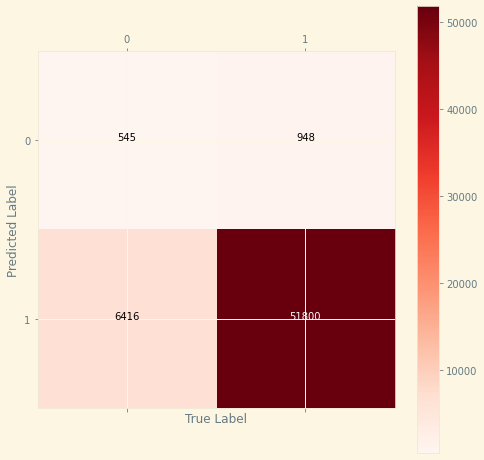

In [145]:
plot_confusion_matrix(xgb_test_result2)

We focus more on Recall rate of 0 class

### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

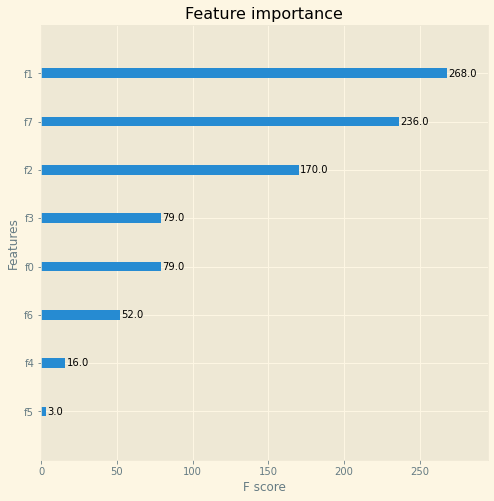

In [153]:
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(model_list2[0],ax=ax)

## Version3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import xgboost as xgb
from collections import Counter
from sklearn.metrics import confusion_matrix
import warnings 
import torch
import torch.nn as nn

from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.dataloaders import DataLoaderImbalanced, DataLoaderDefault
from pytorch_widedeep.models import Wide, TabMlp, WideDeep
from pytorch_widedeep.metrics import Accuracy, F1Score, Precision, Recall
from pytorch_widedeep.datasets import load_adult
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F


warnings.filterwarnings('ignore')


/home/szxie/anaconda3/envs/nerftorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data():
    df_train = pd.read_csv(f'./data/training.csv',index_col='id')
    df_test = pd.read_csv(f'./data/test.csv',index_col='id')

    return df_train, df_test

In [3]:
df_train_val, df_test = load_data()
features =[ 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8']
label = 'event'

scaler = StandardScaler()

for ds in [df_train_val, df_test]:
    tmp = ds.isna().sum()
    for fe in features:
        print(fe)
        set_values = ds[fe].unique()
        na_value = ds[fe].min() - ds[fe].max() # out of distribution value
        ds[fe].fillna(value=na_value, inplace=True)
        # df_train_val.iloc[fe][0:-1] = scaler.fit_transform(df_train_val[fe][0:-1].to_numpy())
        print(ds[fe].min())
        print(ds[fe].max())
        print(tmp[fe], len(ds[fe]) - tmp[fe], len(set_values))


# 
# df_train_val.iloc[:,0:-1] = scaler.fit_transform(df_train_val.iloc[:,0:-1].to_numpy())
# df_test.iloc[:,0:-1] = scaler.fit_transform(df_test.iloc[:,0:-1].to_numpy())

var1
-120.0
121.0
105800 133036 76
var2
-2817427941.438
2817427941.438
121800 117036 93826
var3
-10175.48156420513
10175.48156420513
192199 46637 46116
var4
-12.0
13.0
160649 78187 14
var5
-334283.5571428572
334283.5571428572
230549 8287 8176
var6
-167427.56397849464
164300.40000000002
232897 5939 5926
var7
-22.0
24.0
211294 27542 24
var8
-94.25000000000001
118.66666666666669
137689 101147 5720
var1
-110.0
111.0
26290 33419 62
var2
-1590072360.074
1590072360.074
30310 29399 26616
var3
-8615.982449561667
8615.982449561667
48178 11531 11406
var4
-12.0
13.0
40351 19358 14
var5
-116654.45
116654.45
57604 2105 2085
var6
-19876.064142671574
19484.277852348994
58187 1522 1523
var7
-22.0
24.0
52886 6823 24
var8
-82.91666666666669
107.41666666666669
34458 25251 3240


In [4]:

df_train_val.head()

,event,var1,var2,var3,var4,var5,var6,var7,var8,split
id,,,,,,,,,,
0,1,-120.0,-2.817428e+09,-10175.481564,-12.0,-334283.557143,-167427.563978,-22.0,-94.25,dev
1,1,-120.0,-2.817428e+09,-10175.481564,-12.0,-334283.557143,-167427.563978,-22.0,-94.25,dev
2,1,-120.0,-2.817428e+09,-10175.481564,-12.0,-334283.557143,-167427.563978,-22.0,-94.25,dev
3,1,1.0,2.096510e+07,-10175.481564,-12.0,-334283.557143,-167427.563978,-22.0,62.75,dev
4,1,-120.0,-2.817428e+09,-10175.481564,-12.0,-334283.557143,-167427.563978,-22.0,-94.25,dev


**cat embed:**
var1, var4, var7

**continual:**
var2, var3, var5, var6, var8

In [5]:
from torch import Tensor

class CustomBCELoss(nn.Module):
    def __init__(self, class_weight=0.97) -> None:
        super().__init__()
        self.class_weight = class_weight

    def forward(self, input: Tensor, target: Tensor) -> Tensor:

        input = torch.sigmoid(input)
        loss = (1-self.class_weight) * target * torch.log(input) + self.class_weight * (1 - target) * torch.log(1 - input)

        return torch.neg(torch.mean(loss))


In [6]:
def stats(gts, preds):
    for fn in [accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score]:
        print(fn.__name__, fn(gts, preds))
    cm = confusion_matrix(gts, preds)

    per_cls_acc = cm.astype(
            'float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-7)

    # 可视化混淆矩阵
    fig = plt.figure(figsize=(4, 4))
    sns.heatmap(per_cls_acc, annot=True, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [7]:
wide_cols = [
    "var1",
    "var2",
    "var8",
    "var4"
]
crossed_cols = [("var2", "var8"), ("var1", "var4")]

cat_embed_cols = [
    "var1",
    "var4",
]
continuous_cols = ["var2", "var3", "var8"]

target = "event"
target = df_train_val[target].values

# prepare the data
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_wide = wide_preprocessor.fit_transform(df_train_val)

tab_preprocessor = TabPreprocessor(
    cat_embed_cols=cat_embed_cols, continuous_cols=continuous_cols  # type: ignore[arg-type]
)
X_tab = tab_preprocessor.fit_transform(df_train_val)

# build the model
wide = Wide(input_dim=np.unique(X_wide).shape[0], pred_dim=1)
tab_mlp = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=continuous_cols,
    mlp_hidden_dims=[100],
    mlp_dropout=0.5,
    mlp_activation="leaky_relu",
)
model = WideDeep(wide=wide, deeptabular=tab_mlp)

predict: 100%|██████████| 234/234 [00:05<00:00, 44.17it/s] 


0 class weights: {ratio}
accuracy_score 0.5639685809509454
precision_score 0.9839102583380951
recall_score 0.5619760890476845
f1_score 0.7153618244831469
average_precision_score 0.9800053347392947
roc_auc_score 0.6018185870556573


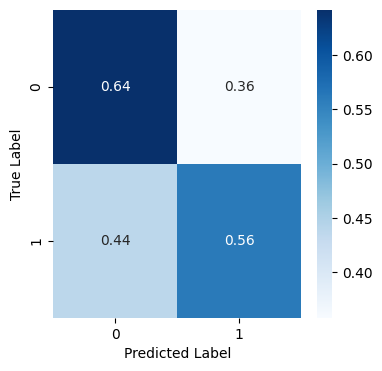

In [17]:
# train and validate
ratio = 0.97 # 0 class weights 0.97, 1 class weights 0.03
trainer = Trainer(
    model, 
    objective="binary", 
    # custom_loss_function=weighted_binary_cross_entropy,
    custom_loss_function=CustomBCELoss(ratio),
    optimizers=torch.optim.AdamW(model.parameters(), lr=0.002),
    custom_dataloader=DataLoaderImbalanced,
    metrics=[Accuracy, F1Score, Precision, Recall]
)

# binary lr=0.05

trainer.fit(
    X_wide=X_wide,
    X_tab=X_tab,
    target=target,
    n_epochs=15,
    batch_size=256,
    val_split=0.2
)

# predict on test
X_wide_te = wide_preprocessor.transform(df_test)
X_tab_te = tab_preprocessor.transform(df_test)
gts = df_test[label].values

preds = trainer.predict(X_wide=X_wide_te, X_tab=X_tab_te)

print('0 class weights: {ratio}')
stats(gts, preds)

torch.save(model.state_dict(), f"model_weights/wd_custom{ratio}_model.pt")

predict: 100%|██████████| 234/234 [00:06<00:00, 34.52it/s] 


0 class weights: {ratio}
accuracy_score 0.9747274280259257
precision_score 0.9751478893301828
recall_score 0.9995533873849114
f1_score 0.9871998235628431
average_precision_score 0.9751478212239917
roc_auc_score 0.503125655514291


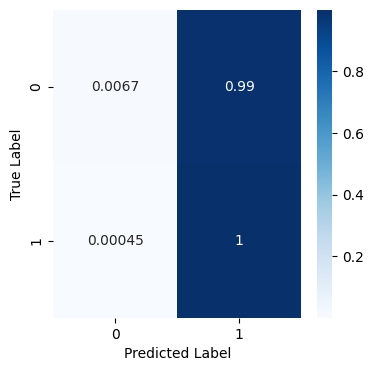

In [10]:
# rebuild model
wide_cols = [
    "var1",
    "var2",
    "var8",
    "var4"
]
crossed_cols = [("var2", "var8"), ("var1", "var4")]

cat_embed_cols = [
    "var1",
    "var4",
]
continuous_cols = ["var2", "var3", "var8"]

target = "event"
target = df_train_val[target].values

# prepare the data
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_wide = wide_preprocessor.fit_transform(df_train_val)

tab_preprocessor = TabPreprocessor(
    cat_embed_cols=cat_embed_cols, continuous_cols=continuous_cols  # type: ignore[arg-type]
)
X_tab = tab_preprocessor.fit_transform(df_train_val)

# build the model
wide = Wide(input_dim=np.unique(X_wide).shape[0], pred_dim=1)
tab_mlp = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=continuous_cols,
    mlp_hidden_dims=[100],
    mlp_dropout=0.5,
    mlp_activation="leaky_relu",
)
model = WideDeep(wide=wide, deeptabular=tab_mlp)

ratio = 0.5 # equal to BCELoss

trainer = Trainer(
    model, 
    objective="binary", 
    # custom_loss_function=weighted_binary_cross_entropy,
    custom_loss_function=CustomBCELoss(ratio),
    optimizers=torch.optim.AdamW(model.parameters(), lr=0.002),
    custom_dataloader=DataLoaderImbalanced,
    metrics=[Accuracy, F1Score, Precision, Recall]
)

# binary lr=0.05

trainer.fit(
    X_wide=X_wide,
    X_tab=X_tab,
    target=target,
    n_epochs=15,
    batch_size=256,
)

# predict on test
test_gts = df_test[label].values

X_wide_te = wide_preprocessor.transform(df_test)
X_tab_te = tab_preprocessor.transform(df_test)

preds = trainer.predict(X_wide=X_wide_te, X_tab=X_tab_te)

print('0 class weights: {ratio}')
stats(test_gts, preds)

torch.save(model.state_dict(), f"model_weights/wd_custom{ratio}_model.pt")


predict: 100%|██████████| 234/234 [00:06<00:00, 34.12it/s]


0 class weights: {ratio}
accuracy_score 0.9741077559496893
precision_score 0.9754992448397383
recall_score 0.998522742888553
f1_score 0.9868767295383938
average_precision_score 0.9754985005229885
roc_auc_score 0.5103129454563328


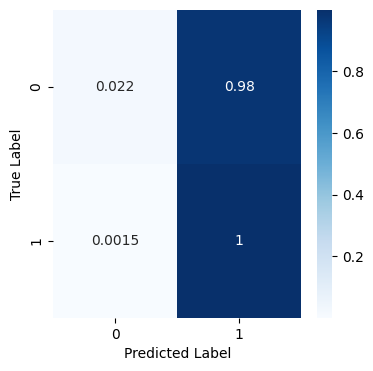

In [11]:
# rebuild model
wide_cols = [
    "var1",
    "var2",
    "var8",
    "var4"
]
crossed_cols = [("var2", "var8"), ("var1", "var4")]

cat_embed_cols = [
    "var1",
    "var4",
]
continuous_cols = ["var2", "var3", "var8"]

target = "event"
target = df_train_val[target].values

# prepare the data
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_wide = wide_preprocessor.fit_transform(df_train_val)

tab_preprocessor = TabPreprocessor(
    cat_embed_cols=cat_embed_cols, continuous_cols=continuous_cols  # type: ignore[arg-type]
)
X_tab = tab_preprocessor.fit_transform(df_train_val)

# build the model
wide = Wide(input_dim=np.unique(X_wide).shape[0], pred_dim=1)
tab_mlp = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=continuous_cols,
    mlp_hidden_dims=[100],
    mlp_dropout=0.5,
    mlp_activation="leaky_relu",
)
model = WideDeep(wide=wide, deeptabular=tab_mlp)

ratio = 0.8 # 0 class weights 0.8, 1 c weights 0.2
trainer = Trainer(
    model, 
    objective="binary", 
    # custom_loss_function=weighted_binary_cross_entropy,
    custom_loss_function=CustomBCELoss(ratio),
    optimizers=torch.optim.AdamW(model.parameters(), lr=0.002),
    custom_dataloader=DataLoaderImbalanced,
    metrics=[Accuracy, F1Score, Precision, Recall]
)

# binary lr=0.05

trainer.fit(
    X_wide=X_wide,
    X_tab=X_tab,
    target=target,
    n_epochs=10,
    batch_size=256,
)


X_wide_te = wide_preprocessor.transform(df_test)
X_tab_te = tab_preprocessor.transform(df_test)

# predict on test
test_gts = df_test[label].values

preds = trainer.predict(X_wide=X_wide_te, X_tab=X_tab_te)

print('0 class weights: {ratio}')
stats(test_gts, preds)

torch.save(model.state_dict(), f"model_weights/wd_custom{ratio}_model.pt")


predict: 100%|██████████| 234/234 [00:07<00:00, 32.77it/s]


accuracy_score 0.974442713828736
precision_score 0.9751886001676446
recall_score 0.9992098392194586
f1_score 0.9870530941917093
average_precision_score 0.9751884475039685
roc_auc_score 0.5039585699781151


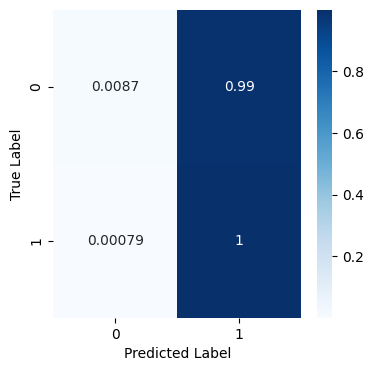

In [14]:
# rebuild model
wide_cols = [
    "var1",
    "var2",
    "var8",
    "var4"
]
crossed_cols = [("var2", "var8"), ("var1", "var4")]

cat_embed_cols = [
    "var1",
    "var4",
]
continuous_cols = ["var2", "var3", "var8"]

target = "event"
target = df_train_val[target].values

# prepare the data
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_wide = wide_preprocessor.fit_transform(df_train_val)

tab_preprocessor = TabPreprocessor(
    cat_embed_cols=cat_embed_cols, continuous_cols=continuous_cols  # type: ignore[arg-type]
)
X_tab = tab_preprocessor.fit_transform(df_train_val)

# build the model
wide = Wide(input_dim=np.unique(X_wide).shape[0], pred_dim=1)
tab_mlp = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=continuous_cols,
    mlp_hidden_dims=[100],
    mlp_dropout=0.5,
    mlp_activation="leaky_relu",
)
model = WideDeep(wide=wide, deeptabular=tab_mlp)

trainer = Trainer(
    model, 
    objective="binary_focal_loss", 
    optimizers=torch.optim.AdamW(model.parameters(), lr=0.002),
    custom_dataloader=DataLoaderImbalanced,
    metrics=[Accuracy, F1Score, Precision, Recall]
)

# binary lr=0.05

trainer.fit(
    X_wide=X_wide,
    X_tab=X_tab,
    target=target,
    n_epochs=10,
    batch_size=256,
)


X_wide_te = wide_preprocessor.transform(df_test)
X_tab_te = tab_preprocessor.transform(df_test)

# predict on test
test_gts = df_test[label].values

preds = trainer.predict(X_wide=X_wide_te, X_tab=X_tab_te)

stats(test_gts, preds)

torch.save(model.state_dict(), f"model_weights/wd_focal_model.pt")


In [12]:
# X_wide_te = wide_preprocessor.transform(df_test)
# X_tab_te = tab_preprocessor.transform(df_test)
# test_gts = df_test[label].values

# model_new = WideDeep(wide=wide, deeptabular=tab_mlp)

# for i, pt_path in enumerate(['wd_custom_new_model.pt', 'wd_focal_loss_model.pt']):
#     model_new.load_state_dict(torch.load(f"model_weights/{pt_path}"))
#     trainer_new = Trainer(model_new, objective="binary")
#     test_preds = trainer_new.predict(X_wide=X_wide_te, X_tab=X_tab_te)
#     model_name = pt_path.split('_')[1]
#     print('----------------------------------------------------------')
#     print(model_name)
#     stats(test_gts, test_preds)
#     print('----------------------------------------------------------\n')
